This notebooks contains all python code to reproduce microbiome results from paper beestrong 2026. R-code can be found here: XXX. Heritability, here: YYY

1. Metadata cleaning
2. Read trimming and host read removal
3. Rarefication experiments
4. Taxonomic classification with Kraken2 and Bracken
5. Genomic Varroa load
6. Abundance tables from Bracken results
7. Symbiosphere characterization (descriptive part)


In [15]:
import pandas as pd
import numpy as np
import subprocess
from tqdm import tqdm as tqdm
from itertools import product, combinations
import glob
import os

from bee_metagenomics_lib import (
    read_bs_ids_file, get_jobs_to_restart, write_array_str, clean_failed_jobs,
    parse_flagstat,
    count_lines_gz,
    get_unmapped_read_nr_flagstat, get_total_read_nr_flagstat, 
    get_kraken2_read_nr, 
    get_desc_taxa,
    parse_breport,
    get_classified_read_nr,
    get_bracken_classified_read_nr
)

from ete3 import NCBITaxa
ncbi = NCBITaxa(dbfile="/cluster/raid/home/f80878961/data/taxa.sqlite", update=False)

import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
shared_data_path = '/cluster/raid/home/f80878961/data/'
script_path = "/cluster/raid/home/f80878961/scripts/tmp_scripts/"

working_path = '/cluster/raid/home/f80878961/beestrong/'
tlf_path = '{}tlf/'.format(working_path)
metadata_path = '{}00_metadata/'.format(working_path)
pp_path = '{}01_preprocessing/'.format(working_path)
tax_prof_path = '{}02_taxonomic_profiling/'.format(working_path)

metadata_fn = '{}beestrong_metadata.csv'.format(metadata_path)
sampled_bs_ids_file = '{}sampled_bs_ids.txt'.format(metadata_path)
all_bs_ids_file = '{}bs_ids.txt'.format(metadata_path)

sra_path = '{}sra/'.format(pp_path) 
fastq_path = '{}fastq/'.format(pp_path) 
bowtie2_path = '{}bowtie2/'.format(pp_path)
idx_name = 'bee3ref_new'
idx_path = '{}{}_bt2idx/'.format(shared_data_path, idx_name)
sample_SRA_file = '{}sample_SRA.csv'.format(tlf_path)

kraken2_path = '{}kraken2/'.format(tax_prof_path)
bracken_path = '{}bracken/'.format(tax_prof_path)
kdb_path = '{}krakdb/'.format(shared_data_path)

In [46]:
pd.read_csv(metadata_fn)

Colony        date      Genetic group  percent_Ligustica_Carnica  \
0     BS16_0001  01/08/2016             hybrid                   0.158920   
1     BS16_0002  01/08/2016             hybrid                   0.001545   
2     BS16_0003  01/08/2016             hybrid                   0.752977   
3     BS16_0004  29/09/2016          Mellifera                   0.066520   
4     BS16_0005  28/07/2016             hybrid                   0.578850   
...         ...         ...                ...                        ...   
1437  BS18_0675  18/10/2018  Ligustica_Carnica                   0.999239   
1438  BS18_0681  17/10/2018             hybrid                   0.582663   
1439  BS18_0682  17/10/2018             hybrid                   0.414228   
1440  BS18_0684  17/10/2018  Ligustica_Carnica                   0.988999   
1441  BS18_0686  17/10/2018             hybrid                   0.252460   

      percent_Mellifera  percent_Caucasica  bee_weigth  nbr_pho_varroa  \
0              0.712885           0.128195        38.5            55.0   
1              0.776361           0.222094        36.1            10.0   
2              0.206098           0.040926        39.0            12.0   
3              0.829661           0.103819        40.7            12.0   
4              0.409558           0.011593        45.0            14.0   
...                 ...                ...         ...             ...   
1437           0.000041           0.000720        45.0             8.0   
1438           0.000738           0.416599        47.0            74.0   
1439           0.395046           0.190726        47.0            35.0   
1440           0.000257           0.010744        64.0            29.0   
1441           0.001730           0.745810        21.0             6.0   

      nbr_pho_varroa_100bee      v_pho  ...       DMR    eb_mmr  \
0                      19.0  20.000000  ...  0.257143  0.282885   
1                       4.0   3.878116  ...  0.257143  0.282885   
2                       4.0   4.307692  ...  0.400000  0.399892   
3                       4.0   4.127764  ...  0.485714  0.470096   
4                       4.0   4.355556  ...  0.250000  0.348465   
...                     ...        ...  ...       ...       ...   
1437                    2.0   2.488889  ...  0.371429  0.376490   
1438                   21.0  22.042553  ...  0.657143  0.610505   
1439                   10.0  10.425532  ...  0.142857  0.189279   
1440                    6.0   6.343750  ...  0.428571  0.423293   
1441                    4.0   4.000000  ...  0.257143  0.282885   

                        Region        Department  Apiary  Year  Month  \
0     provence_alpes_cote_azur          Vaucluse    65.0  2016      8   
1     provence_alpes_cote_azur          Vaucluse    65.0  2016      8   
2     provence_alpes_cote_azur          Vaucluse    65.0  2016      8   
3     provence_alpes_cote_azur          Vaucluse    65.0  2016      9   
4     provence_alpes_cote_azur          Vaucluse    65.0  2016      7   
...                        ...               ...     ...   ...    ...   
1437  provence_alpes_cote_azur          Vaucluse    49.0  2018     10   
1438  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   
1439  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   
1440  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   
1441  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   

      Day of Year  Latitude  Longitude  
0             214      44.0      5.167  
1             214      44.0      5.167  
2             214      44.0      5.167  
3             273      44.0      5.167  
4             210      44.0      5.167  
...           ...       ...        ...  
1437          291      44.0      5.167  
1438          290      43.5      5.167  
1439          290      43.5      5.167  
1440          290      43.5      5.167  
1441          290      43.5      5.167  

[1442 rows x 37 colu

# Metadata cleaning

In [3]:
from datetime import datetime

# original metadata from Sonia
raw_metadata_fn = '{}beestrong_metadata_raw.csv'.format(metadata_path)
apiary_data_fn = '{}Data_loc_rucher_pour_Suisses.csv'.format(metadata_path)

skip_bs_ids = {'BS17_0674', 'BS17_0721'} # no sequence data

## phenotype dataset
new_pheno_df = pd.read_table(raw_metadata_fn)

new_pheno_df = new_pheno_df[~new_pheno_df['num_bs'].isin(skip_bs_ids)].reset_index(drop=True).rename(columns={'num_bs':'Colony'})
loc_df = pd.read_table(apiary_data_fn, sep='\t')
new_pheno_df = new_pheno_df.merge(loc_df.rename(columns={'num_ruche_BS':'Colony', 'rucher_recode': 'Apiary', 'region': 'Region'}), on='Colony', how='left')

# filter colonies from NZ, unknown and with missing apiaries
new_pheno_df = new_pheno_df[(~new_pheno_df['Region'].isin({'new_zealand', 'unknown'})) & (~new_pheno_df['Apiary'].isna())]

# and split date into year and month
new_pheno_df['Year'] = new_pheno_df['date'].map(lambda x: int(str(x).split('/')[2]) if not pd.isna(x) else None)
new_pheno_df['Month'] = new_pheno_df['date'].map(lambda x: int(str(x).split('/')[1]) if not pd.isna(x) else None)
new_pheno_df['Day of Year'] = new_pheno_df['date'].map(lambda x: datetime(*[int(y) for y in x.split('/')][::-1]).timetuple().tm_yday if not pd.isna(x) else None)

# convert apiary to float, will be easier for coloring
new_pheno_df['Apiary'] = new_pheno_df['Apiary'].astype(float)

# add geographic coordinates
departement2lat_lon = {
    'Alpes_de_Haute_Provence': (44.0, 6.167),
    'Ardeche': (44.667, 4.417),
    'Ariege': (43.0, 1.5),
    'Aude': (43.083, 2.417),
    'Bas_Rhin': (48.667, 7.583),
    'Bern': (46.948, 7.447), # Switzerland
    'Bouches_du_Rhone': (43.5, 5.167),
    'Charente_Maritime': (45.75, -0.75),
    'Cher': (47.0, 2.583),
    'Cotes_Darmor': (48.333, 1.167),
    'Dordogne': (45.0, 0.667),
    'Drome': (44.75, 5.167),
    'Finistere': (48.25, 4.0),
    'Gers': (43.717, 0.6),
    'Gironde': (44.833, -0.583),
    'Haut_Rhin': (47.75, 7.25),
    'Haute_Corse': (42.467, 9.2),
    'Haute_Garonne': (43.433, 1.133),
    'Haute_Vienne': (45.867, 1.25),
    'Ille_et_Vilaine': (48.167, 0.333),
    'Isere': (45.333, 5.5),
    'Jura': (47.367, 7.15), # Switzerland
    'Lot_et_Garonne': (44.333, 0.5),
    'Maine_et_Loire': (47.45, -0.6),
    'North_brabant': (51.667, 5), # Netherland
    'Otago': (-45.881, 170.496), # New Zealand
    'Puy_de_Dome': (45.7, 3.217),
    'Pyrenees_Atlantique': (43.25, -0.833),
    'Sarthe': (47.0, 0.317),
    'Savoie': (45.583, 6.167),
    'Tarn': (43.817, 2.2),
    'Tarn_et_Garonne': (44.0, 1.333),
    'Var': (43.5, 6.333),
    'Vastergotland': (57.728, 12.7), # Sweden
    'Vaucluse': (44.0, 5.167),
    'Vendee': (46.667, 0.583),
    'Vianden': (49.9, 6.2), # Luxembourg
    'unknown': (np.nan, np.nan)
}
new_pheno_df['Latitude'] = new_pheno_df['departement'].map(lambda x: departement2lat_lon[x][0])
new_pheno_df['Longitude'] = new_pheno_df['departement'].map(lambda x: departement2lat_lon[x][1])

# fix inconsistency between CH and FR metadata
new_pheno_df['Colony'] = new_pheno_df['Colony'].replace({
    'BS18_0122': 'BS18_0125', 
    'BS18_0123': 'BS18_0126',
    'BS18_0124': 'BS18_0127', 
    'BS18_0125': 'BS18_0128',
    'BS18_0126': 'BS18_0129', 
    'BS18_0127': 'BS18_0122',
    'BS18_0128': 'BS18_0123', 
    'BS18_0129': 'BS18_0124'
})

# some renaming
new_pheno_df = new_pheno_df.rename(columns={'group': 'Genetic group', 'raw_mnr': 'DMR', 'logit_recap_inf': 'Recapping', 'departement': 'Department'})
new_pheno_df = new_pheno_df.sort_values('Colony').reset_index(drop=True)

# write
new_pheno_df.to_csv(metadata_fn, index=False)
pd.read_csv(metadata_fn)

Colony        date      Genetic group  percent_Ligustica_Carnica  \
0     BS16_0001  01/08/2016             hybrid                   0.158920   
1     BS16_0002  01/08/2016             hybrid                   0.001545   
2     BS16_0003  01/08/2016             hybrid                   0.752977   
3     BS16_0004  29/09/2016          Mellifera                   0.066520   
4     BS16_0005  28/07/2016             hybrid                   0.578850   
...         ...         ...                ...                        ...   
1437  BS18_0675  18/10/2018  Ligustica_Carnica                   0.999239   
1438  BS18_0681  17/10/2018             hybrid                   0.582663   
1439  BS18_0682  17/10/2018             hybrid                   0.414228   
1440  BS18_0684  17/10/2018  Ligustica_Carnica                   0.988999   
1441  BS18_0686  17/10/2018             hybrid                   0.252460   

      percent_Mellifera  percent_Caucasica  bee_weigth  nbr_pho_varroa  \
0              0.712885           0.128195        38.5            55.0   
1              0.776361           0.222094        36.1            10.0   
2              0.206098           0.040926        39.0            12.0   
3              0.829661           0.103819        40.7            12.0   
4              0.409558           0.011593        45.0            14.0   
...                 ...                ...         ...             ...   
1437           0.000041           0.000720        45.0             8.0   
1438           0.000738           0.416599        47.0            74.0   
1439           0.395046           0.190726        47.0            35.0   
1440           0.000257           0.010744        64.0            29.0   
1441           0.001730           0.745810        21.0             6.0   

      nbr_pho_varroa_100bee      v_pho  ...       DMR    eb_mmr  \
0                      19.0  20.000000  ...  0.257143  0.282885   
1                       4.0   3.878116  ...  0.257143  0.282885   
2                       4.0   4.307692  ...  0.400000  0.399892   
3                       4.0   4.127764  ...  0.485714  0.470096   
4                       4.0   4.355556  ...  0.250000  0.348465   
...                     ...        ...  ...       ...       ...   
1437                    2.0   2.488889  ...  0.371429  0.376490   
1438                   21.0  22.042553  ...  0.657143  0.610505   
1439                   10.0  10.425532  ...  0.142857  0.189279   
1440                    6.0   6.343750  ...  0.428571  0.423293   
1441                    4.0   4.000000  ...  0.257143  0.282885   

                        Region        Department  Apiary  Year  Month  \
0     provence_alpes_cote_azur          Vaucluse    65.0  2016      8   
1     provence_alpes_cote_azur          Vaucluse    65.0  2016      8   
2     provence_alpes_cote_azur          Vaucluse    65.0  2016      8   
3     provence_alpes_cote_azur          Vaucluse    65.0  2016      9   
4     provence_alpes_cote_azur          Vaucluse    65.0  2016      7   
...                        ...               ...     ...   ...    ...   
1437  provence_alpes_cote_azur          Vaucluse    49.0  2018     10   
1438  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   
1439  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   
1440  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   
1441  provence_alpes_cote_azur  Bouches_du_Rhone    54.0  2018     10   

      Day of Year  Latitude  Longitude  
0             214      44.0      5.167  
1             214      44.0      5.167  
2             214      44.0      5.167  
3             273      44.0      5.167  
4             210      44.0      5.167  
...           ...       ...        ...  
1437          291      44.0      5.167  
1438          290      43.5      5.167  
1439          290      43.5      5.167  
1440          290      43.5      5.167  
1441          290      43.5      5.167  

[1442 rows x 37 colu

# Read trimming and host read removal


In [3]:
def write_preprocessing_mapping_script(script_fn, array_str):
    runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STRING
#SBATCH --nodes=1
#SBATCH --ntasks=8
#SBATCH --mem=60g
#SBATCH --time=12:00:00
#SBATCH --job-name=pp_mapping
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

# module purge
modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
ml SRA-Toolkit
ml cutadapt
ml Trimmomatic/0.39
ml FastQC
ml Bowtie2
ml SAMtools

# file listing all BeeStrong ids (bs_id) for parallel computing
bs_ids_file=$1
sra_path=$2
fastq_path=$3
sample_SRA_file=$4
bowtie2_path=$5
idx_path=$6
idx_name=$7

adaptor_file=$EBROOTTRIMMOMATIC/adapters/TruSeq3-PE-2.fa
ls $adaptor_file

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})

echo "1. find all SRA ids corresponding to the bs_id"
sra_ids=()
for sra in $(grep $bs_id $sample_SRA_file | cut -f 2); do
    sra_ids+=($sra)
    
    # download the SRA file on the go
    if [[ -d "$sra_path/$sra" || -f "$sra_path/$sra.sra" ]]; then
        echo "Skipping $sra: already downloaded"
    else
        echo "downloading $sra"
        prefetch -O $sra_path $sra
    fi
done

fastq_1=$fastq_path${bs_id}_1.fastq
fastq_2=$fastq_path${bs_id}_2.fastq
    
if [[ -f "$fastq_path${bs_id}_1.fastq" || -f "$fastq_path${bs_id}_2.fastq" ]]; then
    echo "2. fastq already dumped"
    ls $fastq_1
    ls $fastq_2
else
    echo "2. concatenate fastq from multiple SRA files"
    # initiate fastq files
    touch $fastq_1
    touch $fastq_2
    for sra in "${sra_ids[@]}"; do
        fasterq-dump $sra_path$sra -O $fastq_path
        # maybe a good idea to cancel the job here if sra.fastq not existing
        cat ${fastq_path}${sra}_1.fastq >> $fastq_1
        cat ${fastq_path}${sra}_2.fastq >> $fastq_2
        rm -f ${fastq_path}${sra}_1.fastq
        rm -f ${fastq_path}${sra}_2.fastq
    done
fi

echo "3. trim poly-G tails with cutadapt"
fastq_1_t=$fastq_path${bs_id}_1_cut.fastq
fastq_2_t=$fastq_path${bs_id}_2_cut.fastq

# cutadapt -a "G{10}" -A "G{10}" -m 50 -o $fastq_1_t -p $fastq_2_t $fastq_1 $fastq_2
cutadapt -j 8 -a "file:$adaptor_file" -A "file:$adaptor_file" -a "G{10}" -A "G{10}" -m 50 -o $fastq_1_t -p $fastq_2_t $fastq_1 $fastq_2

mv -f $fastq_1_t $fastq_1
mv -f $fastq_2_t $fastq_2

echo "4. FastQC"
fastqc $fastq_1 $fastq_2

echo "5. compress"
gzip -f $fastq_1 $fastq_2

echo "6. copy to home and clean"
rm  -f $fastq_1 $fastq_2

#### Mapping 

fastq_1=$fastq_path${bs_id}_1.fastq.gz
fastq_2=$fastq_path${bs_id}_2.fastq.gz
ls -lh $fastq_1
ls -lh $fastq_2

echo "7. bowtie2"
unmapped_prefix=${bowtie2_path}${bs_id}_${idx_name}_unmapped
mapped_prefix=${bowtie2_path}${bs_id}_${idx_name}_mapped
bowtie2 -x  ${idx_path}${idx_name} -p 8 -1 $fastq_1 -2 $fastq_2 -S ${mapped_prefix}.sam > ${bowtie2_path}${bs_id}_${idx_name}.out 2>&1

echo "8. SAM to BAM"
samtools view -S -b ${mapped_prefix}.sam > ${mapped_prefix}.bam
rm -f ${mapped_prefix}.sam

# no need for the original fastq and sra --> we only keep the unmapped sequences
rm -f $fastq_1
rm -f $fastq_2
for sra in "${sra_ids[@]}"; do
    rm -rf $sra_path$sra
done

# samtools sort & flagstat (for comparison with bwa-mem2)
echo "9. sorting bam files and write flagstats"
samtools sort ${mapped_prefix}.bam > ${mapped_prefix}.sorted.bam
samtools flagstat ${mapped_prefix}.sorted.bam > ${mapped_prefix}.flagstat

# thibault stringent approach to remove bee reads
# Regenerate fastq files by removing all reads with mapped reads against at least one of the three A. mellifera genomes (for paired-end reads, I am conservative. If a read of the pair is mapped against one of the three genomes, I exclude that pair, i.e. -f 12)
echo "10. extracting unmapped reads"
samtools view -f 12 -b ${mapped_prefix}.sorted.bam > ${unmapped_prefix}.sorted.bam
samtools fastq -1 ${unmapped_prefix}.1.fastq -2 ${unmapped_prefix}.2.fastq -s ${unmapped_prefix}_singletons.fastq ${unmapped_prefix}.sorted.bam

echo "11. delete and compress"
rm -f ${mapped_prefix}.bam
rm -f ${mapped_prefix}.sorted.bam
rm -f ${unmapped_prefix}.sorted.bam
rm -f ${unmapped_prefix}_singletons.fastq
gzip -f ${unmapped_prefix}.1.fastq 
gzip -f ${unmapped_prefix}.2.fastq

echo DONE""".replace("ARRAY_STRING", array_str)
    with open(script_fn, 'w') as outf:
        outf.write(runstr)

In [4]:
bs_ids_file = sampled_bs_ids_file
bs_ids_file = all_bs_ids_file
array_id2bs_id, bs_id2array_id = read_bs_ids_file(bs_ids_file)

In [5]:
step_name = 'pp_mapping'
exp_files = [
    '{}BSID_1_fastqc.html'.format(fastq_path), 
    '{}BSID_2_fastqc.html'.format(fastq_path), 
    '{}BSID_1_fastqc.zip'.format(fastq_path), 
    '{}BSID_2_fastqc.zip'.format(fastq_path), 
    '{}BSID_{}.out'.format(bowtie2_path, idx_name), 
    '{}BSID_{}_mapped.flagstat'.format(bowtie2_path, idx_name), 
    '{}BSID_{}_unmapped.1.fastq.gz'.format(bowtie2_path, idx_name),
    '{}BSID_{}_unmapped.2.fastq.gz'.format(bowtie2_path, idx_name)
]

In [6]:
pp_jobs_to_run, pp_completed_jobs = get_jobs_to_restart(step_name, array_id2bs_id, array_id2bs_id, bowtie2_path, exp_files)
pp_jobs_to_run, pp_completed_jobs

([1029,
  1036,
  1039,
  1045,
  1069,
  1080,
  1114,
  1115,
  1118,
  1121,
  1132,
  1135,
  1139,
  1142,
  645,
  1158,
  1162,
  1168,
  1180,
  671,
  1183,
  1188,
  1192,
  1203,
  1209,
  1227,
  1235,
  1236,
  1248,
  741,
  742,
  1257,
  1261,
  761,
  762,
  766,
  767,
  784,
  790,
  792,
  794,
  1320,
  817,
  1336,
  828,
  1366,
  1371,
  873,
  877,
  1392,
  1399,
  894,
  1406,
  907,
  1422,
  925,
  931,
  1445,
  1447,
  1449,
  1453,
  944,
  945,
  953,
  958,
  966,
  1480,
  989],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82

In [8]:
sorted(pp_jobs_to_run)

[645,
 671,
 741,
 742,
 761,
 762,
 766,
 767,
 784,
 790,
 792,
 794,
 817,
 828,
 873,
 877,
 894,
 907,
 925,
 931,
 944,
 945,
 953,
 958,
 966,
 989,
 1029,
 1036,
 1039,
 1045,
 1069,
 1080,
 1114,
 1115,
 1118,
 1121,
 1132,
 1135,
 1139,
 1142,
 1158,
 1162,
 1168,
 1180,
 1183,
 1188,
 1192,
 1203,
 1209,
 1227,
 1235,
 1236,
 1248,
 1257,
 1261,
 1320,
 1336,
 1366,
 1371,
 1392,
 1399,
 1406,
 1422,
 1445,
 1447,
 1449,
 1453,
 1480]

In [9]:
# # careful here
# failed_array_ids = sorted(pp_jobs_to_run)
# clean_failed_jobs(failed_array_ids, array_id2bs_id, exp_files, bowtie2_path, step_name)
# # errors come from failure to download the SRA

In [11]:
sorted(pp_jobs_to_run)

[645,
 671,
 741,
 742,
 761,
 762,
 766,
 767,
 784,
 790,
 792,
 794,
 817,
 828,
 873,
 877,
 894,
 907,
 925,
 931,
 944,
 945,
 953,
 958,
 966,
 989,
 1029,
 1036,
 1039,
 1045,
 1069,
 1080,
 1114,
 1115,
 1118,
 1121,
 1132,
 1135,
 1139,
 1142,
 1158,
 1162,
 1168,
 1180,
 1183,
 1188,
 1192,
 1203,
 1209,
 1227,
 1235,
 1236,
 1248,
 1257,
 1261,
 1320,
 1336,
 1366,
 1371,
 1392,
 1399,
 1406,
 1422,
 1445,
 1447,
 1449,
 1453,
 1480]

In [12]:
# most efficient is actually to run things in home 
pp_jobs_to_run = sorted(pp_jobs_to_run)
# array_str = ','.join([str(x) for x in pp_jobs_to_run])
array_str = write_array_str(pp_jobs_to_run) #, min(64, len(pp_jobs_to_run))) # 32 * 8  = 256 (2 machine filled max) --> should do 100 jobs in 12h
array_str = '645,671,741-742,761-762,766-767,784,790,792,794,817,828,873,877,894,907,925,931,944-945,953,958,966,989,1029,1036,1039,1045,1069,1080,1114-1115,1118,1121,1132,1135,1139,1142,1158,1162,1168,1180,1183,1188,1192,1203,1209,1227,1235-1236,1248,1257,1261,1320,1336,1366,1371,1392,1399,1406,1422,1445,1447,1449,1453,1454,1480%100'
pp_mapping_script = '{}{}.run'.format(script_path, step_name)
write_preprocessing_mapping_script(pp_mapping_script, array_str)
print(pp_mapping_script)
array_str

/cluster/raid/home/f80878961/scripts/tmp_scripts/pp_mapping.run


'645,671,741-742,761-762,766-767,784,790,792,794,817,828,873,877,894,907,925,931,944-945,953,958,966,989,1029,1036,1039,1045,1069,1080,1114-1115,1118,1121,1132,1135,1139,1142,1158,1162,1168,1180,1183,1188,1192,1203,1209,1227,1235-1236,1248,1257,1261,1320,1336,1366,1371,1392,1399,1406,1422,1445,1447,1449,1453,1454,1480%100'

In [13]:
bs_ids_file, sra_path, fastq_path, sample_SRA_file, bowtie2_path, idx_path, idx_name

('/cluster/raid/home/f80878961/beestrong/00_metadata/bs_ids.txt',
 '/cluster/raid/home/f80878961/beestrong/01_preprocessing/sra/',
 '/cluster/raid/home/f80878961/beestrong/01_preprocessing/fastq/',
 '/cluster/raid/home/f80878961/beestrong/tlf/sample_SRA.csv',
 '/cluster/raid/home/f80878961/beestrong/01_preprocessing/bowtie2/',
 '/cluster/raid/home/f80878961/data/bee3ref_new_bt2idx/',
 'bee3ref_new')

In [14]:
command = ['sbatch', pp_mapping_script, bs_ids_file, sra_path, fastq_path, sample_SRA_file, bowtie2_path, idx_path, idx_name]
result = subprocess.run(command, cwd=bowtie2_path, capture_output=False)

Submitted batch job 1418585


# Taxonomic classification with Kraken2 and Bracken

In [165]:
def write_kraken2_script(kraken2_script_fn, array_str, read_pool, min_hit_grps, confidence):
    conf_str = str(confidence).replace('.', '')
    kraken2_runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STR
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=400g
#SBATCH --time=02:00:00
#SBATCH --job-name=kraken2
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
conda activate planb
which kraken2
which bracken

kdb_path=$1
kdb_name=$2
bowtie2_path=$3
kraken2_path=$4
bracken_path=$5
bs_ids_file=$6

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})

fastq_1=${bowtie2_path}${bs_id}_bee3ref_new_unmapped.1.fastq.gz
fastq_2=${bowtie2_path}${bs_id}_bee3ref_new_unmapped.2.fastq.gz
ls -lh $fastq_1
ls -lh $fastq_2

file_id=${bs_id}_${kdb_name}_READPOOL_mhgMINHITGROUP_csCONFIDENCESTRING_sf1_rep1
echo $file_id


if [ ! -f ${kraken2_path}${file_id}.kraken2 ]; then
    echo '1. kraken2'
    kraken2 --threads 8 --db ${kdb_path}${kdb_name} --paired --report-minimizer-data --minimum-hit-groups MINHITGROUP --confidence CONFIDENCESCORE --gzip-compressed \
    --output ${kraken2_path}${file_id}.kraken2 --report ${kraken2_path}${file_id}.k2report ${fastq_1} ${fastq_2} --unclassified-out ${kraken2_path}${file_id}_uc#.fastq # this force kraken2 to put reads filtered by mhg in kraken2 output
    rm -f ${kraken2_path}${file_id}_uc_1.fastq ${kraken2_path}${file_id}_uc_2.fastq
fi

echo '2. bracken'
bracken -d ${kdb_path}${kdb_name} -i ${kraken2_path}${file_id}.k2report -r 150 -l F -t 10 -o ${bracken_path}${file_id}_F.bracken -w ${bracken_path}${file_id}_F.breport
bracken -d ${kdb_path}${kdb_name} -i ${kraken2_path}${file_id}.k2report -r 150 -l G -t 10 -o ${bracken_path}${file_id}_G.bracken -w ${bracken_path}${file_id}_G.breport
bracken -d ${kdb_path}${kdb_name} -i ${kraken2_path}${file_id}.k2report -r 150 -l S -t 10 -o ${bracken_path}${file_id}_S.bracken -w ${bracken_path}${file_id}_S.breport

echo DONE""".replace('ARRAY_STR', array_str).replace('READPOOL', read_pool).replace('MINHITGROUP', min_hit_grps).replace('CONFIDENCESTRING', conf_str).replace('CONFIDENCESCORE', confidence)
    with open(kraken2_script_fn, 'w') as outf:
        outf.write(kraken2_runstr)

In [166]:
kdb_name = 'corent'
# kdb_name = 'class_krakdb'
bs_ids_file = sampled_bs_ids_file
read_pool = 'nonbee'
mhg = '2'

# cs = '0.05'
cs = '0.25'
cs = '0.50'

array_id2bs_id, bs_id2array_id = read_bs_ids_file(bs_ids_file)

In [167]:
step_name = 'kraken2'
job_id = "*"
job_id = 1416686
k2_exp_files = [
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1.kraken2'.format(kraken2_path, kdb_name, read_pool, mhg, str(cs).replace('.', '')), 
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1.k2report'.format(kraken2_path, kdb_name, read_pool, mhg, str(cs).replace('.', ''))]
brack_exp_files = [
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1_S.bracken'.format(bracken_path, kdb_name, read_pool, mhg, str(cs).replace('.', '')), 
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1_S.breport'.format(bracken_path, kdb_name, read_pool, mhg, str(cs).replace('.', '')), 
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1_F.bracken'.format(bracken_path, kdb_name, read_pool, mhg, str(cs).replace('.', '')), 
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1_F.breport'.format(bracken_path, kdb_name, read_pool, mhg, str(cs).replace('.', '')), 
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1_G.bracken'.format(bracken_path, kdb_name, read_pool, mhg, str(cs).replace('.', '')), 
    '{}BSID_{}_{}_mhg{}_cs{}_sf1_rep1_G.breport'.format(bracken_path, kdb_name, read_pool, mhg, str(cs).replace('.', '')), 
]

k2_jobs_to_run, k2_completed_jobs = get_jobs_to_restart(step_name, array_id2bs_id, array_id2bs_id, kraken2_path, k2_exp_files + brack_exp_files, job_id)
k2_jobs_to_run, k2_completed_jobs

([], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [59]:
# most efficient is actually to run things in home 
array_str = write_array_str(k2_jobs_to_run, min(len(k2_jobs_to_run), 10))
kraken2_script = '{}kraken2.run'.format(script_path)
write_kraken2_script(kraken2_script, array_str, read_pool, mhg, cs)
array_str

'1-20%10'

In [60]:
command = ['sbatch', kraken2_script, kdb_path, kdb_name, bowtie2_path, kraken2_path, bracken_path, bs_ids_file]
result = subprocess.run(command, cwd=kraken2_path, capture_output=False)

Submitted batch job 1416686


In [61]:
# check consistency in read numbers between my different files
krakdb, readpool, mhg, cs = ('corent', 'nonbee', '2', '025')
for i in tqdm(list(array_id2bs_id)):# :k2_completed_jobs):
    bs_id = array_id2bs_id[i]
    flagstat_res = parse_flagstat('{}{}_{}_mapped.flagstat'.format(bowtie2_path, bs_id, idx_name))
    fastq_1_read_nr = count_lines_gz('{}{}_{}_unmapped.1.fastq.gz'.format(bowtie2_path, bs_id, idx_name)) / 4
    fastq_2_read_nr = count_lines_gz('{}{}_{}_unmapped.2.fastq.gz'.format(bowtie2_path, bs_id, idx_name)) / 4
    assert fastq_1_read_nr == fastq_2_read_nr
    assert fastq_1_read_nr == get_unmapped_read_nr_flagstat(bowtie2_path, bs_id, idx_name)
    assert fastq_1_read_nr == get_kraken2_read_nr(kraken2_path, bs_id, krakdb, readpool, mhg, cs, 1, 1)

100%|██████████| 20/20 [01:36<00:00,  4.85s/it]


## Database and Confidence Score evaluation

1. How do proportions of classified reads and relative abundance of key taxa correlate between reference database and Kraken2 confidence score thresholds?

In [17]:
array_id2bs_id, bs_id2array_id = read_bs_ids_file(sampled_bs_ids_file)
bs_ids = list(bs_id2array_id)

In [18]:
taxa = set(('root', 'Viruses','Bacteria', 'Archaea', 'Eukaryota', 'Embryophyta', 'Fungi', 'Metazoa', 'Anthophila', 'Varroidae'))
taxon2name = {'root': 'Other Root', 'Eukaryota': 'Other Eukaryota', 'Metazoa': 'Other Metazoa', 'Viruses': 'DNA viruses', 'Anthophila': 'Bee leftovers'}
taxa_names = [taxon2name.get(x, x) for x in taxa]
name2tid = {taxon2name.get(k, k): v[0] for k, v in ncbi.get_name_translator(taxa).items()}
tree = ncbi.get_topology(list(name2tid.values()))
print(tree)


                  /-109261
            /- /-|
         /-|      \-3042114
        |  |
      /-|   \-4751
     |  |
     |   \-3193
   /-|
  |  |--2
--|  |
  |   \-2157
  |
   \-10239


In [19]:
readpool, mhg, sf, r, level = ('nonbee', 2, 1, 1, 'G')
databases = ['corent'] #, 'class_krakdb']
cs_thresholds = ['005', '025', '050']

settings =  product(databases, cs_thresholds)
# settings = list(product(databases[:1], cs_thresholds)) + [(databases[1], cs_thresholds[0])]

In [20]:
columns = ['Colony', 'DB', 'CS', 'Category', 'Read Number', 'Relative Abundance', 'Log Relative Abundance']
rows = []

for bs_id, (krakdb, cs) in product(bs_ids, settings):

    total_read_nr = get_total_read_nr_flagstat(bowtie2_path, bs_id, idx_name)
    unmapped_read_nr = get_unmapped_read_nr_flagstat(bowtie2_path, bs_id, idx_name)

    # get number of reads classified by Kraken2 + Bracken
    try:
        taxa2seqnr = parse_breport(bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, taxa)
    except FileNotFoundError:
        continue

    k2_c_read_nr = taxa2seqnr['root']
    rows.append((bs_id, krakdb, cs, 'Classified', k2_c_read_nr, k2_c_read_nr / unmapped_read_nr, np.log(k2_c_read_nr / unmapped_read_nr)))

    # get total number of classified reads, including mapped reads (+ pseudo count): used as denominator for relative abundances
    total_c_read_nr = get_classified_read_nr(bowtie2_path, kraken2_path, bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, idx_name) + 1

    for taxon in taxa:
        name = taxon2name.get(taxon, taxon)
        node = tree&name2tid[name]
        read_nr = taxa2seqnr.get(taxon, 0) - sum([taxa2seqnr.get(x, 0) for x in get_desc_taxa(node, taxa.difference({node.sci_name}))])

        # add pseudo count and calculate relative abundance
        read_nr += 1
        rel_abund = read_nr  / total_c_read_nr
        rows.append((bs_id, krakdb, cs, name, read_nr, rel_abund, np.log(rel_abund)))

cat_df = pd.DataFrame(data=rows, columns=columns)

# quick sanity check : sum of read numbers of taxa == classified read number
for bs_id, (krakdb, cs) in product(bs_ids, settings):
    np.sum(cat_df[(cat_df['Category'] != 'Classified') & (cat_df['Colony'] == bs_id)]['Read Number']) == \
    cat_df[(cat_df['Category'] == 'Classified') & (cat_df['Colony'] == bs_id)] + len(taxa) # because pseudo counts
    
cat_df

Colony      DB   CS       Category  Read Number  Relative Abundance  \
0    BS16_0117  corent  005     Classified      1799404        6.743768e-01   
1    BS16_0117  corent  005          Fungi        42066        9.659458e-04   
2    BS16_0117  corent  005       Bacteria      1701690        3.907527e-02   
3    BS16_0117  corent  005  Bee leftovers        15449        3.547496e-04   
4    BS16_0117  corent  005      Varroidae            1        2.296263e-08   
..         ...     ...  ...            ...          ...                 ...   
655  BS16_0392  corent  050        Archaea            1        2.968878e-08   
656  BS16_0392  corent  050     Other Root            2        5.937756e-08   
657  BS16_0392  corent  050  Other Metazoa          672        1.995086e-05   
658  BS16_0392  corent  050    DNA viruses            1        2.968878e-08   
659  BS16_0392  corent  050    Embryophyta          798        2.369165e-05   

     Log Relative Abundance  
0                 -0.393966  
1                 -6.942403  
2                 -3.242265  
3                 -7.944098  
4                -17.589398  
..                      ...  
655              -17.332497  
656              -16.639349  
657              -10.822238  
658              -17.332497  
659              -10.650388  

[660 rows x 7 columns]

In [21]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1)

### Databases

Text(0, 0.5, 'Non-Bee Unclassified')

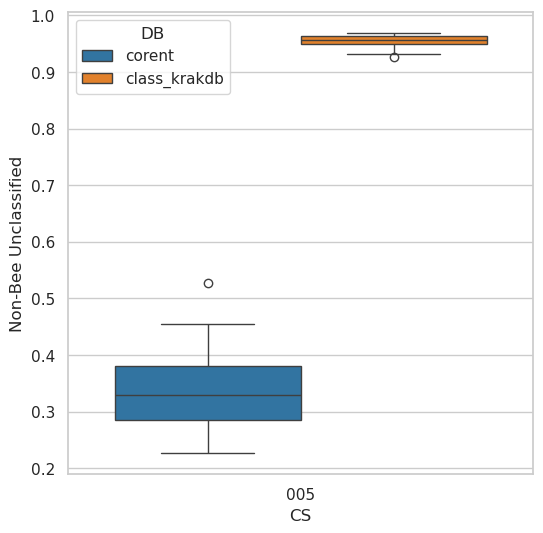

In [33]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=cat_df[(cat_df['Category'] == 'Non-Bee Unclassified') & (cat_df['CS'].isin({'005'}))], x='CS', hue='DB', y='Relative Abundance', legend=True, log_scale=False)
plt.ylabel('Non-Bee Unclassified')

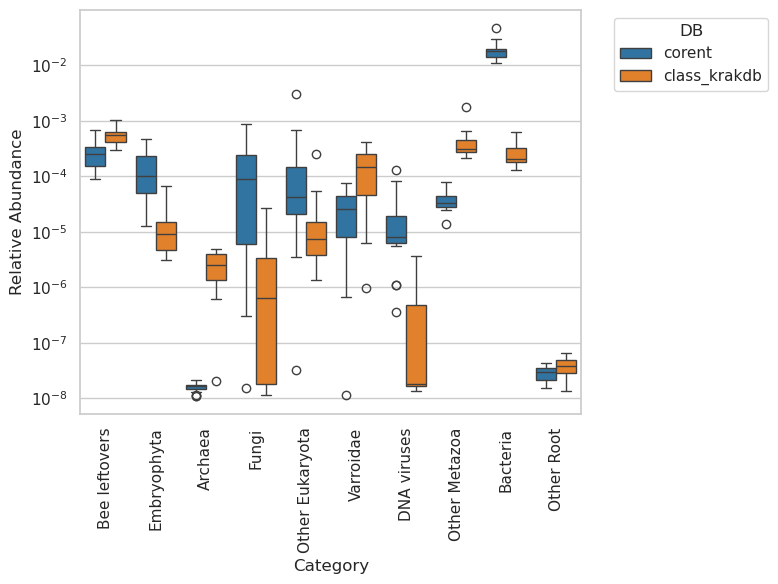

In [29]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=cat_df[(cat_df['Category'].isin(taxa_names)) & (cat_df['CS'].isin({'005'}))], x='Category', hue='DB', y='Relative Abundance', legend=True, log_scale=True)
plt.xticks(rotation=90)

# Manually add the legend to the right side
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='DB', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

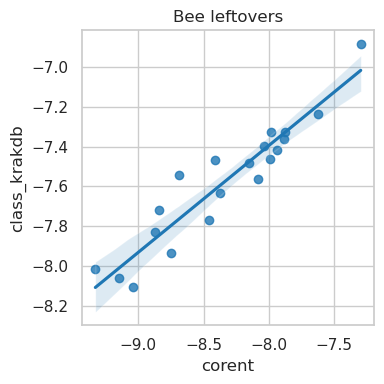

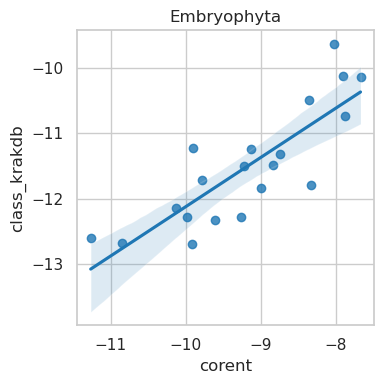

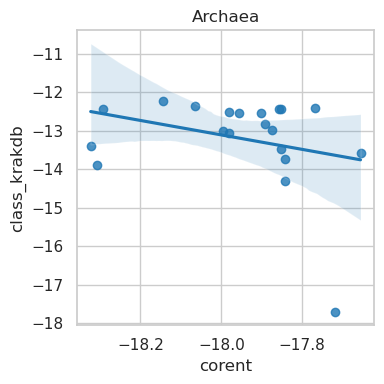

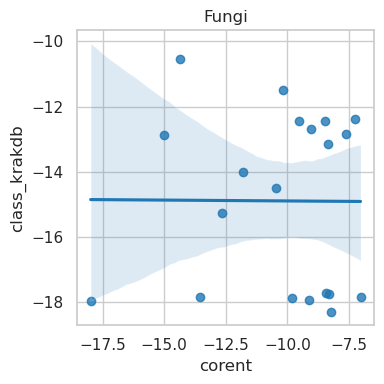

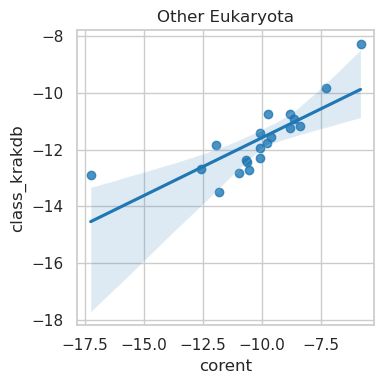

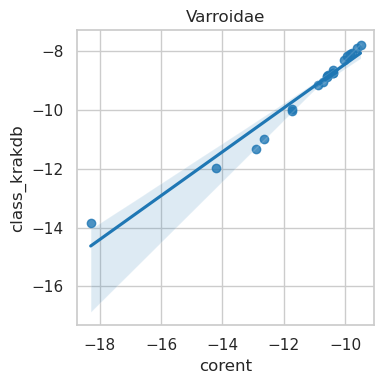

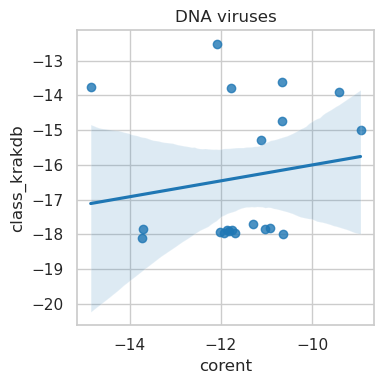

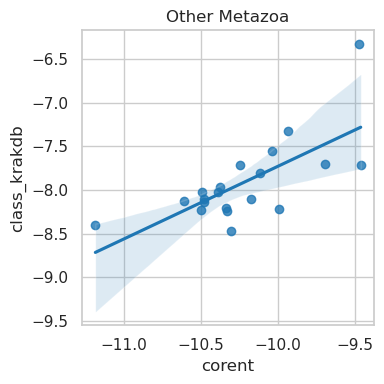

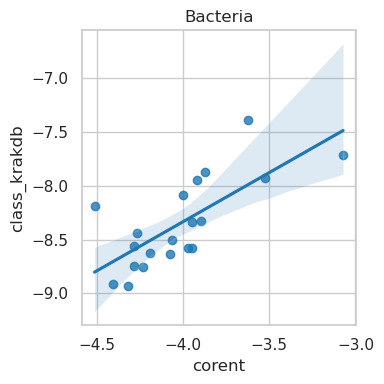

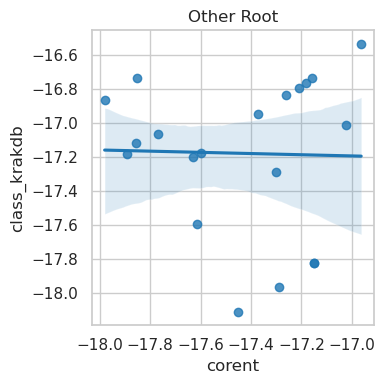

In [31]:
for taxon in taxa_names:
    pivot_df = cat_df[(cat_df['Category'] == taxon)  & (cat_df['CS'].isin({'005'}))].pivot_table(values='Log Relative Abundance', index = 'Colony', columns='DB')
    plt.figure(figsize=(4, 4))
    ax = sns.regplot(pivot_df, x = 'corent', y = 'class_krakdb')
    ax.set_title(taxon)
    plt.tight_layout()
    plt.show()

### Confidence scores

Text(0, 0.5, 'Kraken2 Classified')

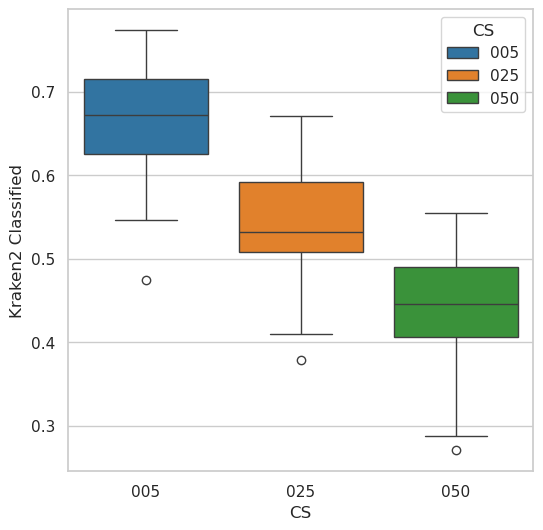

In [16]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=cat_df[(cat_df['Category'] == 'Classified') & (cat_df['DB'].isin({'corent'}))], x='CS', hue='CS', y='Relative Abundance', legend=True, log_scale=False)
plt.ylabel('Kraken2 Classified')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Fungi'),
  Text(1, 0, 'Bacteria'),
  Text(2, 0, 'Bee leftovers'),
  Text(3, 0, 'Varroidae'),
  Text(4, 0, 'Other Eukaryota'),
  Text(5, 0, 'Archaea'),
  Text(6, 0, 'Other Root'),
  Text(7, 0, 'Other Metazoa'),
  Text(8, 0, 'DNA viruses'),
  Text(9, 0, 'Embryophyta')])

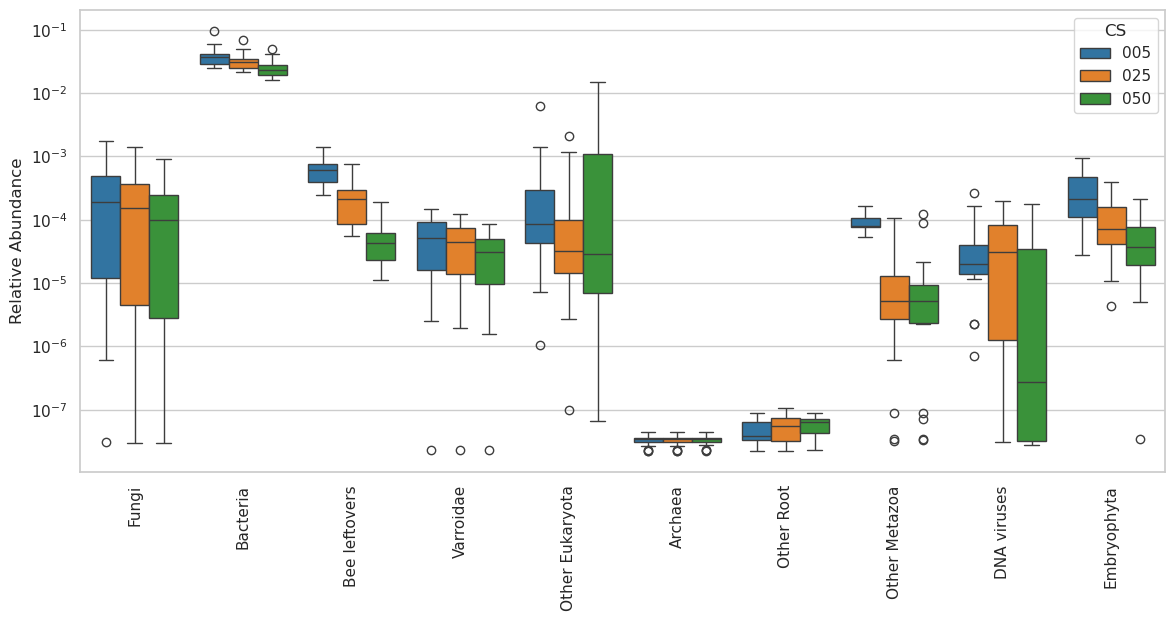

In [22]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=cat_df[cat_df['Category'].isin(taxa_names)], x='Category', hue='CS', y='Relative Abundance', legend=True, log_scale=True)
plt.xlabel(None)
plt.xticks(rotation=90)

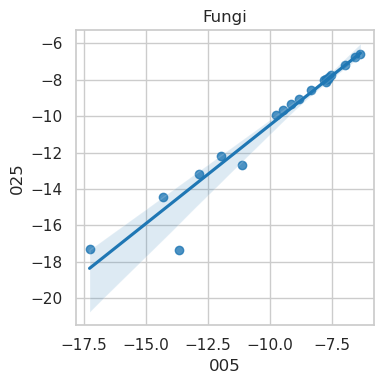

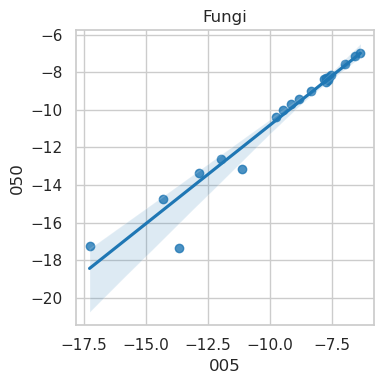

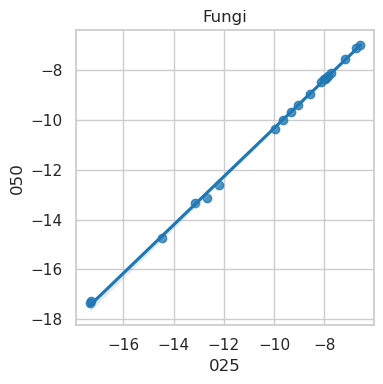

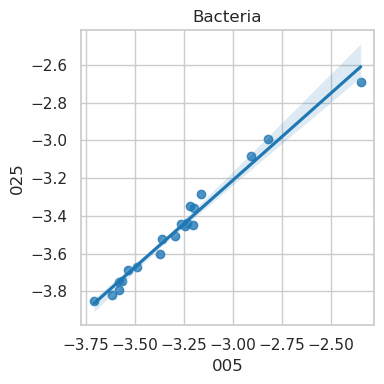

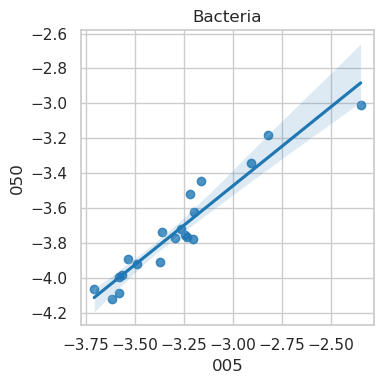

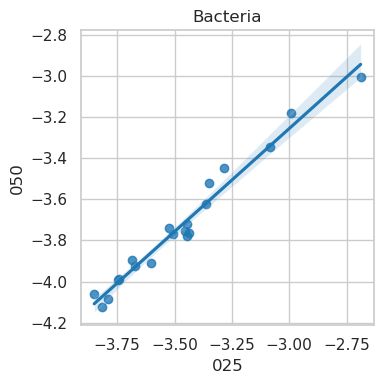

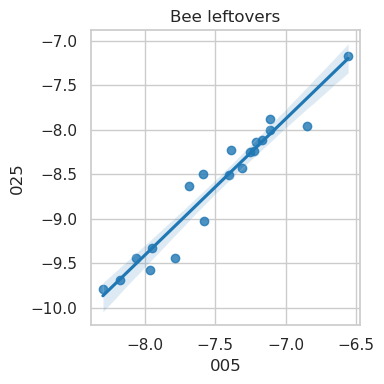

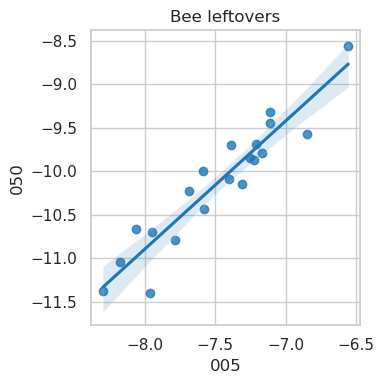

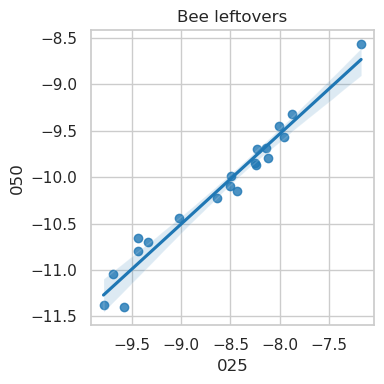

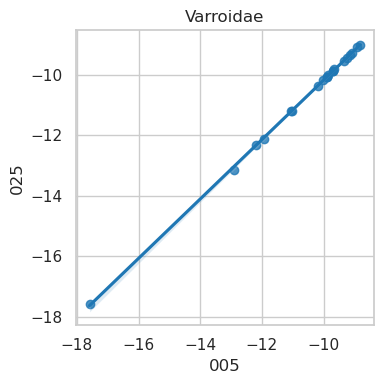

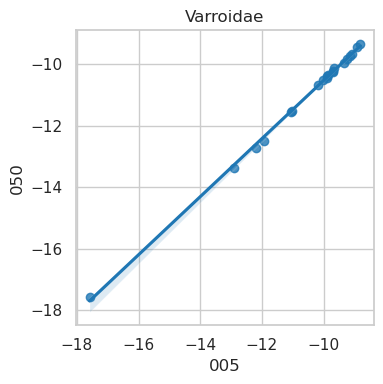

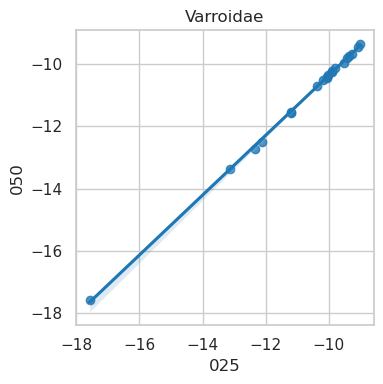

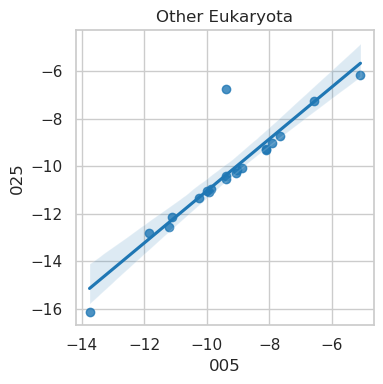

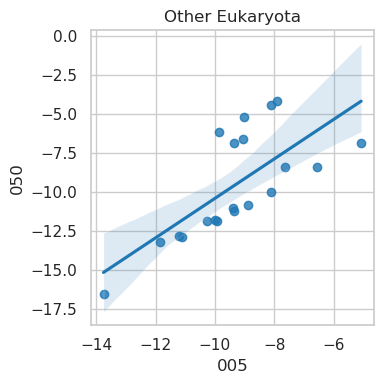

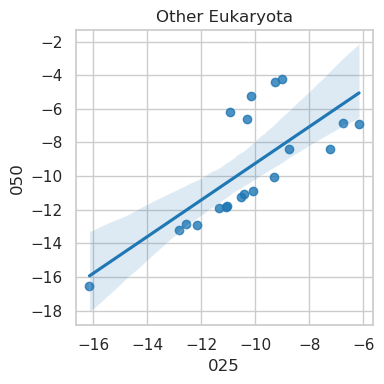

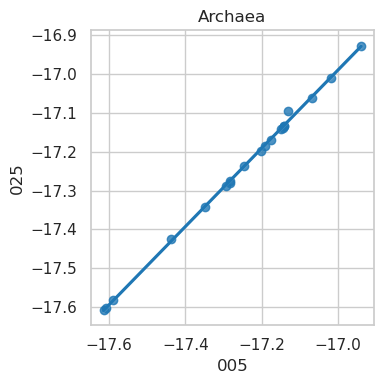

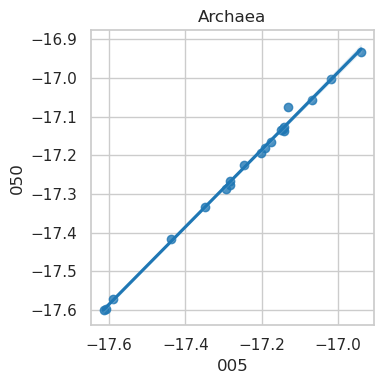

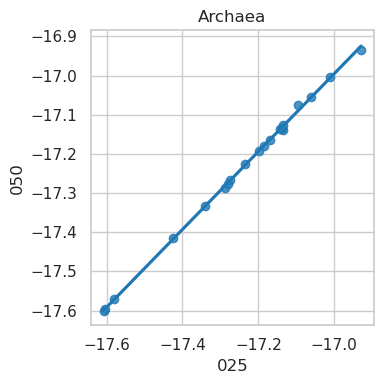

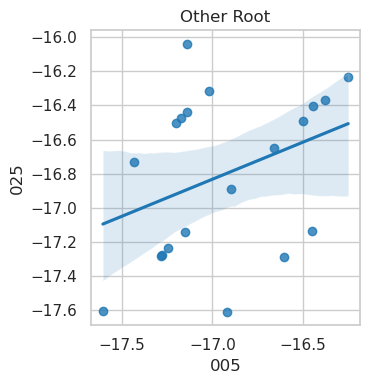

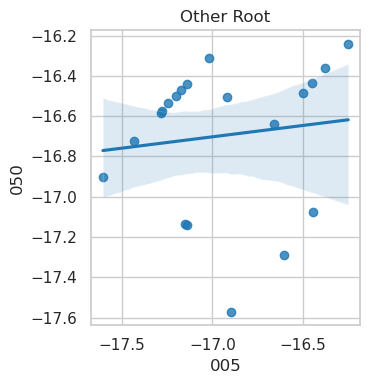

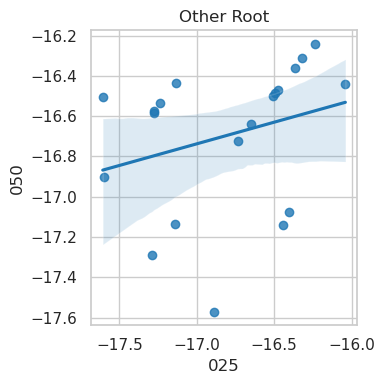

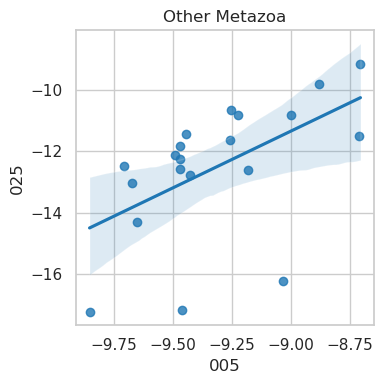

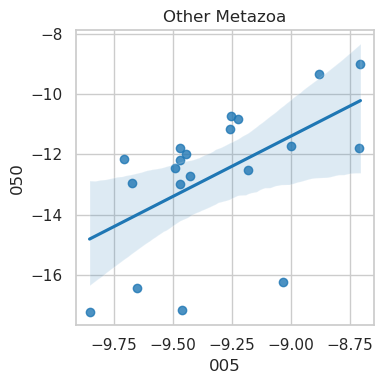

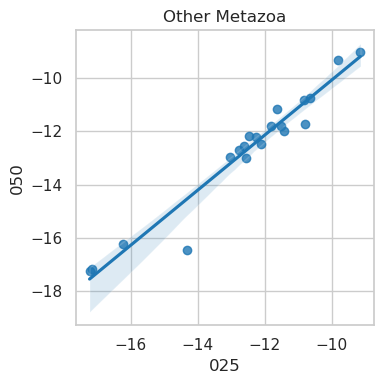

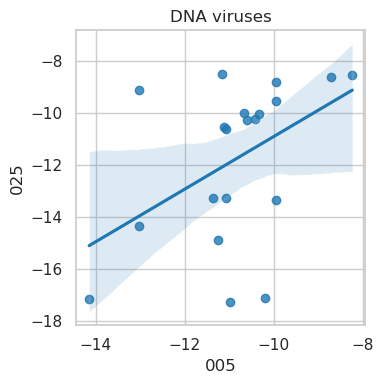

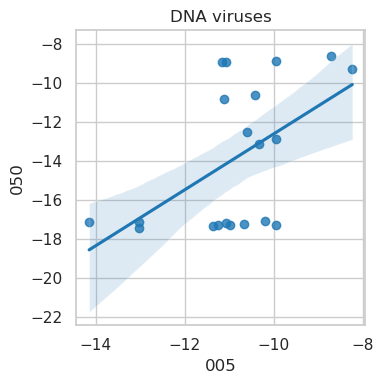

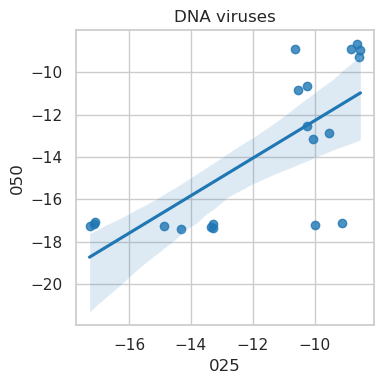

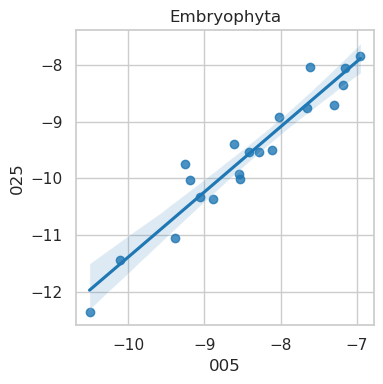

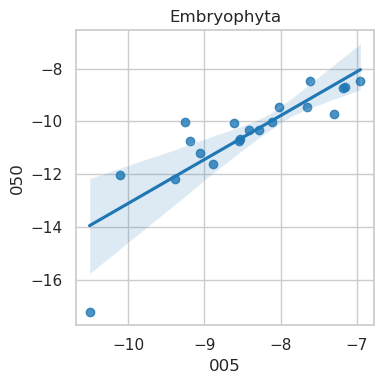

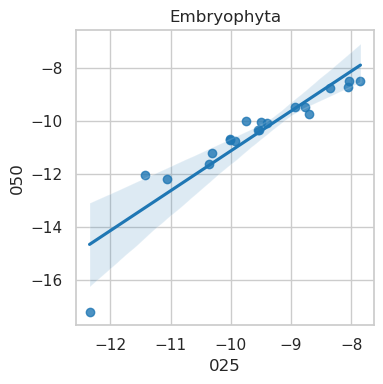

In [23]:
for taxon in taxa_names:
    for cs1, cs2 in list(combinations(cs_thresholds, 2)):
        pivot_df = cat_df[cat_df['Category'] == taxon].pivot_table(values='Log Relative Abundance', index = 'Colony', columns='CS')
        plt.figure(figsize=(4, 4))
        ax = sns.regplot(pivot_df, x = cs1, y = cs2)
        ax.set_title(taxon)
        plt.tight_layout()
        plt.show()

##  Rarefaction and BEExact analyses

What is the optimal choice of confidence score and Limit of Detection (on relative abundance) according to rarefaction and BEExact analyses? 

1. What are the values that maximize the number of identified taxa while removing the library size bias?
2. What are the values that maximize the proportion of BEExact taxa?

steps:
1. subsample the .kraken2 outputs (randomly take 10%, 20%, ... of reads in the .kraken2 file)
2. rebuild .k2report and run bracken

### subsample Kraken2 and run Bracken

In [164]:
def write_rarefication_script(rarefication_script_fn, array_str):
    rarefication_runstr="""#!/bin/bash -l
#SBATCH --array=ARRAY_STR
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=20g
#SBATCH --time=02:00:00
#SBATCH --job-name=rarefication
#SBATCH --output=%x_%A_%a.out
#SBATCH --error=%x_%A_%a.err

modulesld
ebld
module use /software/anaconda3/envs/eb/easybuild/modules/all
conda activate planb

kraken2_path=$1
bs_ids_file=$2
krakdb=$3
readpool=$4
mhg=$5
kdb_path=$6
max_read_nr=$7
make_kreport_script=$8
bracken_path=$9

# getting bs_id
bs_id=$(sed -n ${SLURM_ARRAY_TASK_ID}'{p;q}' ${bs_ids_file})

python ~/scripts/plan-b-omics/bin/rarefy_kraken2.py --kraken2_path ${kraken2_path} --bs_id ${bs_id} --krakdb ${krakdb} --readpool ${readpool} --mhg ${mhg} --kdb_path ${kdb_path} --max_read_nr ${max_read_nr} --make_kreport_script ${make_kreport_script} --bracken_path ${bracken_path}""".replace('ARRAY_STR', array_str)
    with open(rarefication_script_fn, 'w') as outf:
        outf.write(rarefication_runstr)

def get_max_read_nr(bs_ids, bowtie2_path, idx_name):
    return int(max([get_unmapped_read_nr_flagstat(bowtie2_path, bs_id, idx_name) for bs_id in bs_ids]))

def get_min_read_nr(bs_ids, bowtie2_path, idx_name):
    return int(min([get_unmapped_read_nr_flagstat(bowtie2_path, bs_id, idx_name) for bs_id in bs_ids]))

In [165]:
array_id2bs_id, bs_id2array_id = read_bs_ids_file(sampled_bs_ids_file)
bs_ids = list(bs_id2array_id)
bs_ids

['BS16_0117',
 'BS17_0009',
 'BS16_0071',
 'BS17_1465',
 'BS17_0051',
 'BS17_0202',
 'BS17_0005',
 'BS17_0147',
 'BS17_0737',
 'BS18_0056',
 'BS18_0073',
 'BS17_0174',
 'BS16_0413',
 'BS18_0140',
 'BS17_0446',
 'BS16_0306',
 'BS17_0485',
 'BS17_0187',
 'BS17_0095',
 'BS16_0392']

In [61]:
rare_jobs_to_run = list(array_id2bs_id)
rare_jobs_to_run

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [166]:
array_id2bs_id

{1: 'BS16_0117',
 2: 'BS17_0009',
 3: 'BS16_0071',
 4: 'BS17_1465',
 5: 'BS17_0051',
 6: 'BS17_0202',
 7: 'BS17_0005',
 8: 'BS17_0147',
 9: 'BS17_0737',
 10: 'BS18_0056',
 11: 'BS18_0073',
 12: 'BS17_0174',
 13: 'BS16_0413',
 14: 'BS18_0140',
 15: 'BS17_0446',
 16: 'BS16_0306',
 17: 'BS17_0485',
 18: 'BS17_0187',
 19: 'BS17_0095',
 20: 'BS16_0392'}

In [168]:
rare_jobs_to_run = [13, 14]

In [170]:
array_str = write_array_str(rare_jobs_to_run, min(64, len(rare_jobs_to_run)))
rarefication_script = '{}rarefication.run'.format(script_path)
array_str = '13,14'
write_rarefication_script(rarefication_script, array_str)
print(rarefication_script)
array_str

/cluster/raid/home/f80878961/scripts/tmp_scripts/rarefication.run


'13,14'

In [171]:
krakdb, readpool, mhg = ('corent', 'nonbee', 2)
min_read_nr = get_min_read_nr(bs_ids, bowtie2_path, idx_name)
print(min_read_nr)
make_kreport_script = '/cluster/raid/home/f80878961/scripts/KrakenTools/make_kreport.py'

1074999


In [172]:
rarefication_script, kraken2_path, sampled_bs_ids_file, krakdb, readpool, str(mhg), kdb_path, str(int(min_read_nr)), make_kreport_script, bracken_path

('/cluster/raid/home/f80878961/scripts/tmp_scripts/rarefication.run',
 '/cluster/raid/home/f80878961/beestrong/02_taxonomic_profiling/kraken2/',
 '/cluster/raid/home/f80878961/beestrong/00_metadata/sampled_bs_ids.txt',
 'corent',
 'nonbee',
 '2',
 '/cluster/raid/home/f80878961/data/krakdb/',
 '1074999',
 '/cluster/raid/home/f80878961/scripts/KrakenTools/make_kreport.py',
 '/cluster/raid/home/f80878961/beestrong/02_taxonomic_profiling/bracken/')

In [173]:
command = ['sbatch', rarefication_script, kraken2_path, sampled_bs_ids_file, krakdb, readpool, str(mhg), kdb_path, str(int(min_read_nr)), make_kreport_script, bracken_path]
result = subprocess.run(command, cwd=bracken_path, capture_output=False)

Submitted batch job 1417101


### Plot rarefication curves

In [30]:
def get_bracken_df(
    bowtie2_path, kraken2_path, bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, idx_name, taxon_filter):
    '''
    parse bracken file
    '''
    ## parse bracken output
    bracken_fn = '{}{}_{}_{}_mhg{}_cs{}_sf{}_rep{}_{}.bracken'.format(bracken_path, bs_id, krakdb, readpool, mhg, cs, str(sf).replace('.', ''), r, level)
    if not os.path.exists(bracken_fn): 
        print('missing {}'.format(bracken_fn))
        return pd.DataFrame()
    bracken_df = pd.read_csv(bracken_fn, sep='\t')
    
    ## get the number of classified reads (denominator for relative abundance calculations)
    c_read_nr = int(get_classified_read_nr(bowtie2_path, kraken2_path, bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, level, idx_name))

    ## for honey bees, add reads mapping to reference genomes to the one classified to the honey bee taxon (important to compute ratio, e.g., for Varroa load phenotype)
    if level == 'S':
        honeybee_taxon = 'Apis mellifera'
    elif level == 'G':
        honeybee_taxon = 'Apis'
    elif level == 'F':
        honeybee_taxon = 'Apidae'
    else:
        print('wrong honeybee taxonomic level')

    # the number of honey bee reads equals the total number of classified reads minus the one not mapping to the honey bee taxon
    honeybee_read_nr = c_read_nr - bracken_df[bracken_df['name'] != honeybee_taxon]['new_est_reads'].sum()
    if np.sum(bracken_df['name'] == honeybee_taxon) > 0:
        bracken_df.loc[bracken_df['name'] == honeybee_taxon, 'new_est_reads'] = honeybee_read_nr
    else:
        bracken_df.loc[-1] = [honeybee_taxon, np.nan, level, 0, 0, honeybee_read_nr, 0] # case where no remaining honey bee reads
   
    ## recompute relative abundance
    bracken_df['fraction_total_reads'] = bracken_df['new_est_reads'].to_numpy() / c_read_nr
    bracken_df['Log Relative Abundance'] = np.log((bracken_df['new_est_reads'].to_numpy()) / (c_read_nr))
    if not round(np.sum(bracken_df['fraction_total_reads']), 4) == 1: 
        print(bs_id, cs, sf, level)
    
    ## calculate Additive Log Ratio (with honey bee as reference)
    bracken_df['ratio_honeybee'] = bracken_df['new_est_reads'].to_numpy() / honeybee_read_nr
    bracken_df['log_ratio_honeybee'] = np.log((bracken_df['new_est_reads'].to_numpy()) / (honeybee_read_nr))
            
    if taxon_filter:
        return bracken_df[bracken_df['taxonomy_id'].isin(taxon_filter)]
    else:
        return bracken_df

In [192]:
array_id2bs_id, bs_id2array_id = read_bs_ids_file(sampled_bs_ids_file)
bs_ids = list(bs_id2array_id)
krakdb, readpool, mhg = ('corent', 'nonbee', 2)
subsampling_fractions = [round(x, 2) for x in np.arange(0.1, 1, 0.1)]
replicate_nr = 1
replicates = range(1, replicate_nr + 1)
cs_thresholds = ['005', '025', '050']
levels = ['S', 'G', 'F']
lods = [1e-06, 5e-06, 1e-05, 5e-05, 1e-04]
lods = [0, 1e-06, 2e-06, 3e-06, 4e-06, 5e-06] #, 6e-06]
lods = [0, 5e-06, 1e-05]

cmap = dict(zip(lods, sns.color_palette('colorblind', len(lods))))

In [193]:
columns= ['Colony', 'CS', 'Sampling Fraction', 'Replicate Nr', 'Level', 'LoD', 'Richness', 'Delta Richness']
rows = []

for bs_id in tqdm(bs_ids):
    print(bs_id)
    for cs, lvl, sf, r in product(cs_thresholds, levels, subsampling_fractions, replicates):
        
        brack_df = get_bracken_df(bowtie2_path, kraken2_path, bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, lvl, idx_name, {})
        if brack_df.empty:
            continue
        
        for lod in lods:
            richness = len(brack_df[brack_df['fraction_total_reads'] >= lod])
            if sf > subsampling_fractions[0]:
                delta_richness = richness - len(previous_brack_df[previous_brack_df['fraction_total_reads'] >= lod])
            else:
                delta_richness = np.nan 
                
            rows.append((
                bs_id, 
                cs,
                sf,
                r,
                lvl,
                lod, 
                richness,
                delta_richness
            ))

        previous_brack_df = brack_df

rare_df = pd.DataFrame(data=rows, columns=columns)
rare_df

  0%|          | 0/20 [00:00<?, ?it/s]

BS16_0117


  5%|▌         | 1/20 [00:00<00:10,  1.89it/s]

BS17_0009


 10%|█         | 2/20 [00:01<00:09,  1.89it/s]

BS16_0071


 15%|█▌        | 3/20 [00:01<00:08,  1.89it/s]

BS17_1465


 20%|██        | 4/20 [00:02<00:08,  1.91it/s]

BS17_0051


 25%|██▌       | 5/20 [00:02<00:07,  1.91it/s]

BS17_0202


 30%|███       | 6/20 [00:03<00:07,  1.91it/s]

BS17_0005


 35%|███▌      | 7/20 [00:03<00:06,  1.90it/s]

BS17_0147


 40%|████      | 8/20 [00:04<00:06,  1.90it/s]

BS17_0737


 45%|████▌     | 9/20 [00:04<00:05,  1.91it/s]

BS18_0056


 50%|█████     | 10/20 [00:05<00:05,  1.91it/s]

BS18_0073


 55%|█████▌    | 11/20 [00:05<00:04,  1.92it/s]

BS17_0174


 60%|██████    | 12/20 [00:06<00:04,  1.92it/s]

BS16_0413


 65%|██████▌   | 13/20 [00:06<00:03,  1.92it/s]

BS18_0140


 70%|███████   | 14/20 [00:07<00:03,  1.91it/s]

BS17_0446


 75%|███████▌  | 15/20 [00:07<00:02,  1.90it/s]

BS16_0306


 80%|████████  | 16/20 [00:08<00:02,  1.90it/s]

BS17_0485


 85%|████████▌ | 17/20 [00:08<00:01,  1.91it/s]

BS17_0187


 90%|█████████ | 18/20 [00:09<00:01,  1.91it/s]

BS17_0095


 95%|█████████▌| 19/20 [00:09<00:00,  1.91it/s]

BS16_0392


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Colony   CS  Sampling Fraction  Replicate Nr Level       LoD  \
0     BS16_0117  005                0.1             1     S  0.000000   
1     BS16_0117  005                0.1             1     S  0.000005   
2     BS16_0117  005                0.1             1     S  0.000010   
3     BS16_0117  005                0.2             1     S  0.000000   
4     BS16_0117  005                0.2             1     S  0.000005   
...         ...  ...                ...           ...   ...       ...   
4855  BS16_0392  050                0.8             1     F  0.000005   
4856  BS16_0392  050                0.8             1     F  0.000010   
4857  BS16_0392  050                0.9             1     F  0.000000   
4858  BS16_0392  050                0.9             1     F  0.000005   
4859  BS16_0392  050                0.9             1     F  0.000010   

      Richness  Delta Richness  
0           72             NaN  
1           72             NaN  
2           66             NaN  
3           96            24.0  
4           85            13.0  
...        ...             ...  
4855        16             0.0  
4856        16             0.0  
4857        19             0.0  
4858        16             0.0  
4859        16             0.0  

[4860 rows x 8 columns]

In [178]:
[int(sf * min_read_nr) for sf in subsampling_fractions]

[107499, 214999, 322499, 429999, 537499, 644999, 752499, 859999, 967499]

In [179]:
np.unique(rare_df[(rare_df['CS'] == '005') & (rare_df['Level'] == 'S') & (rare_df['LoD'] == 0)]['Sampling Fraction'], return_counts=True)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([20, 20, 20, 20, 20, 20, 20, 20, 20]))

rarefication curves per colony

In [197]:
40000000 / 1000000

40.0

In [210]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1)

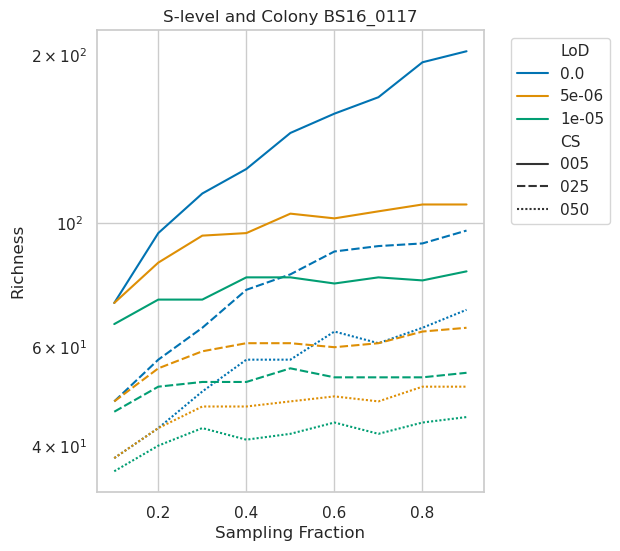

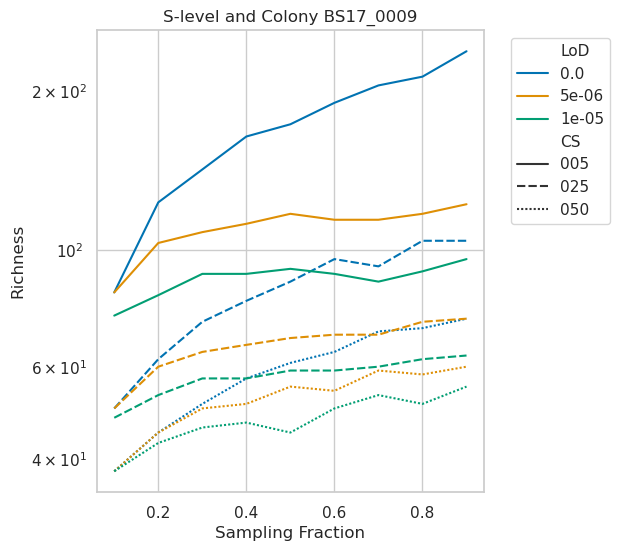

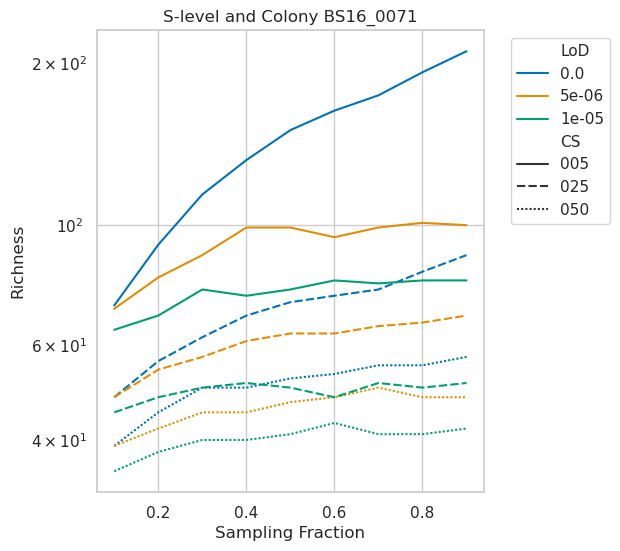

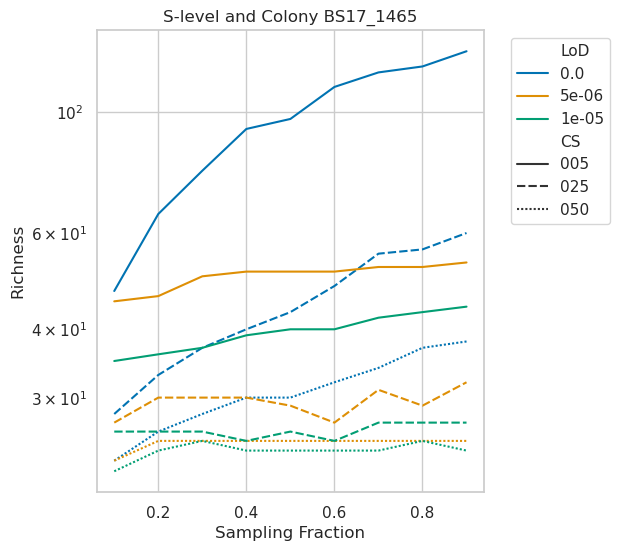

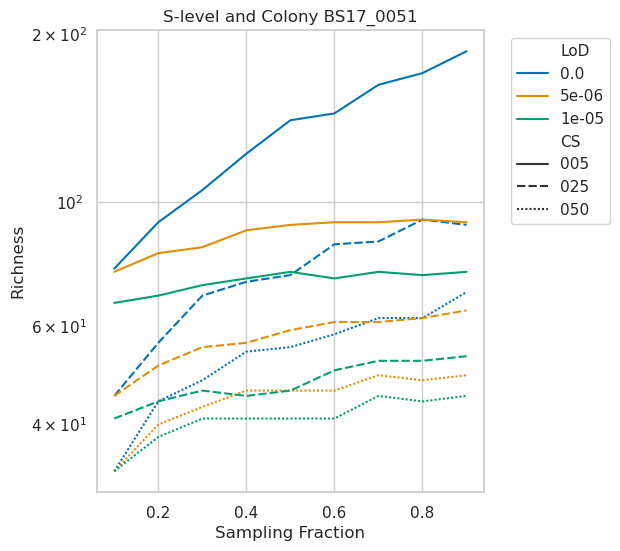

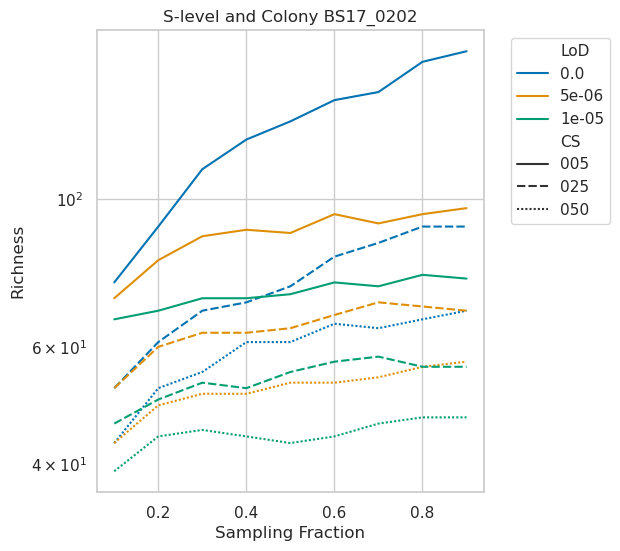

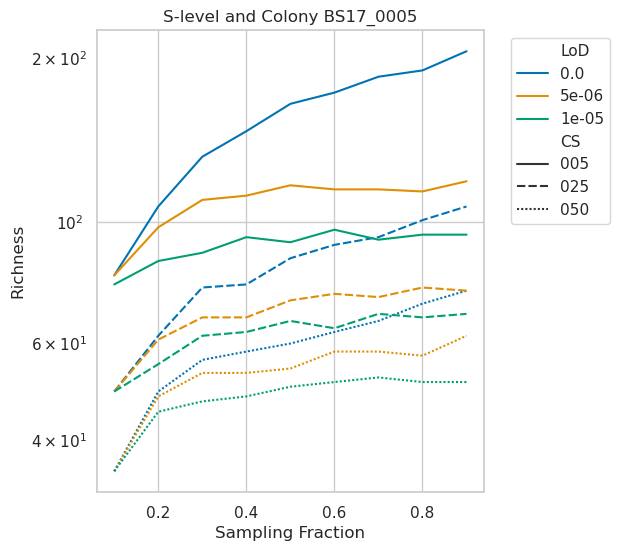

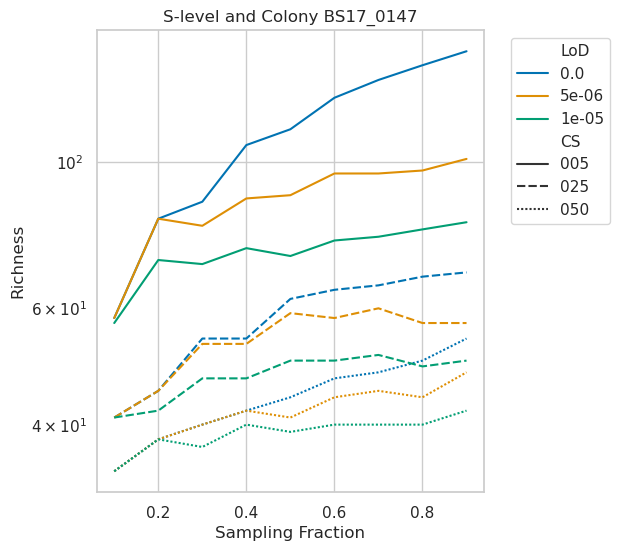

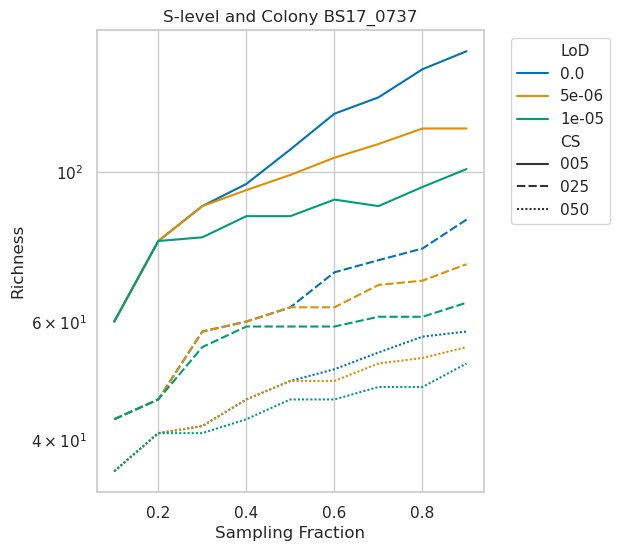

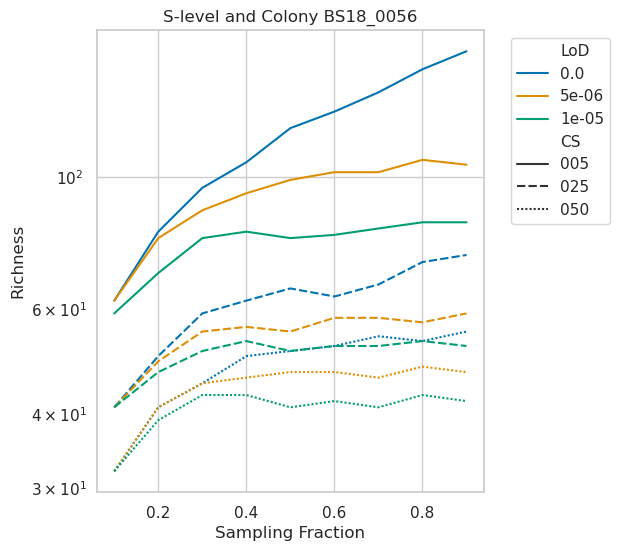

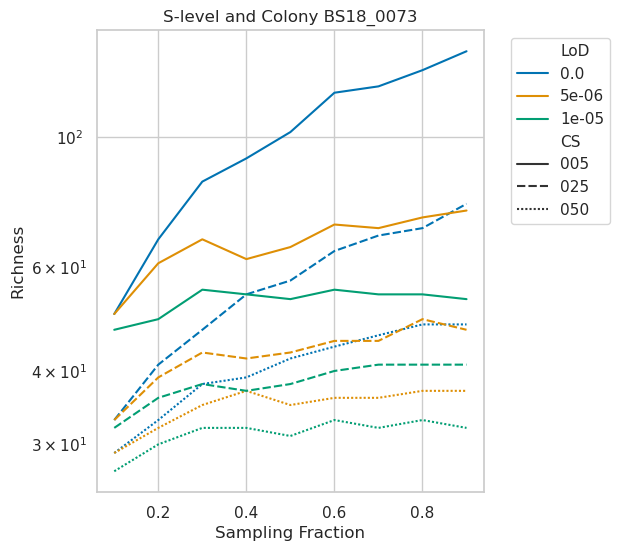

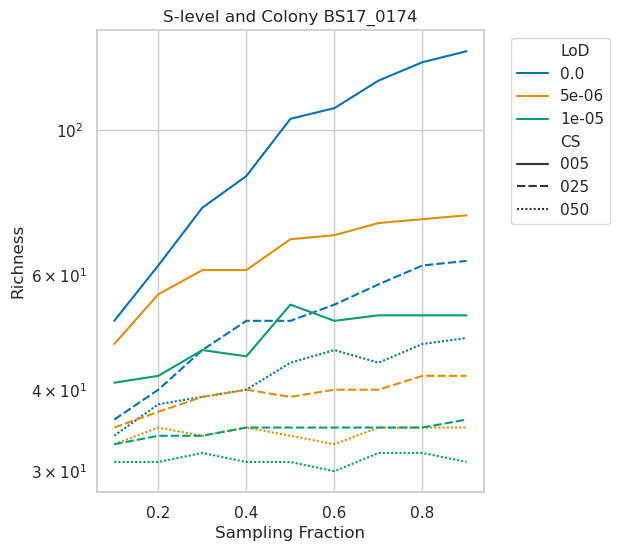

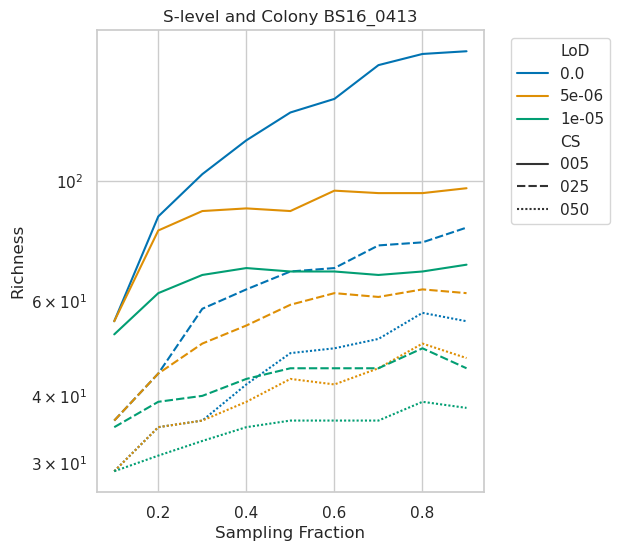

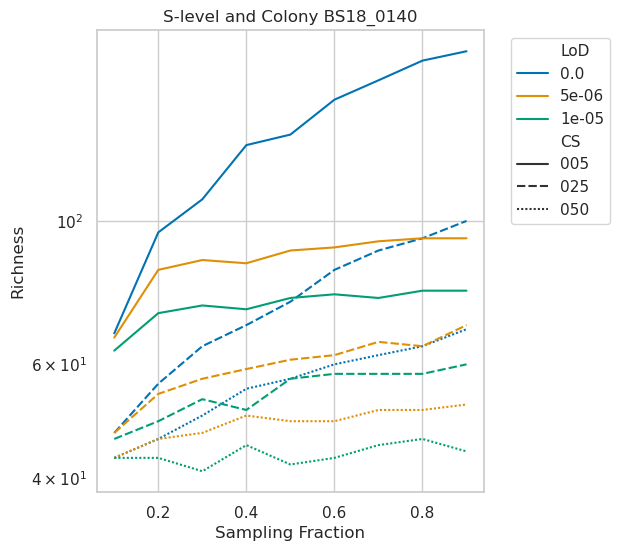

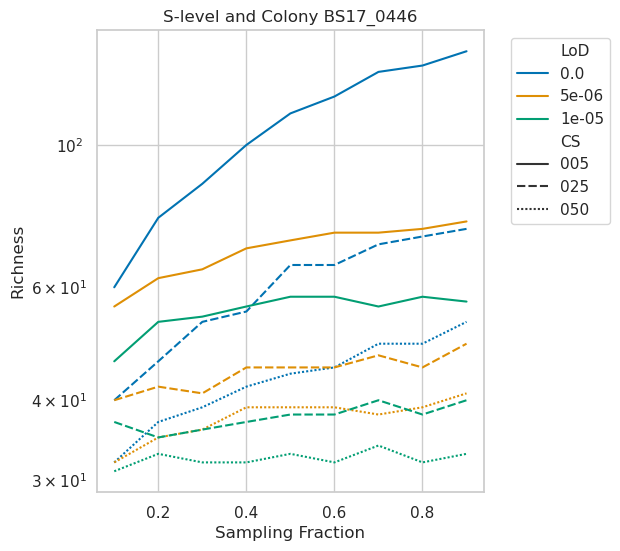

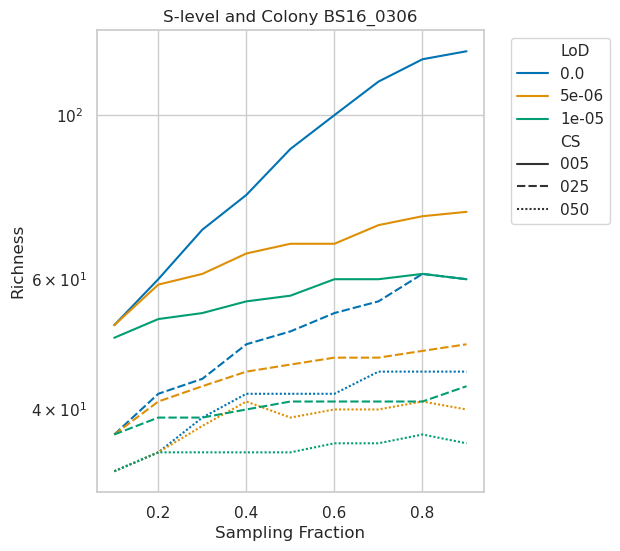

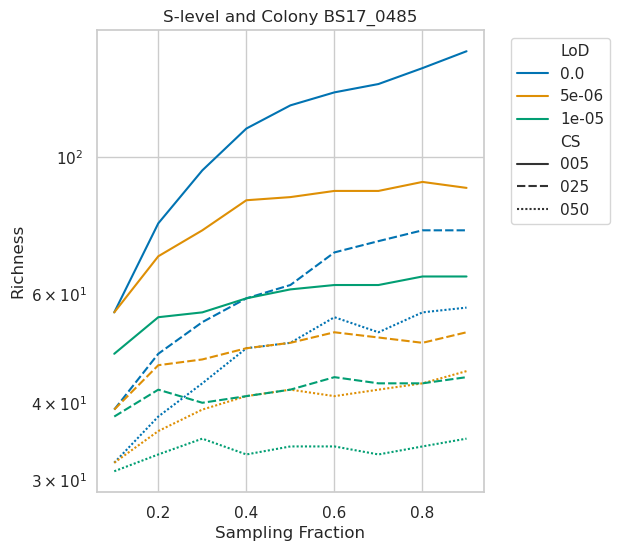

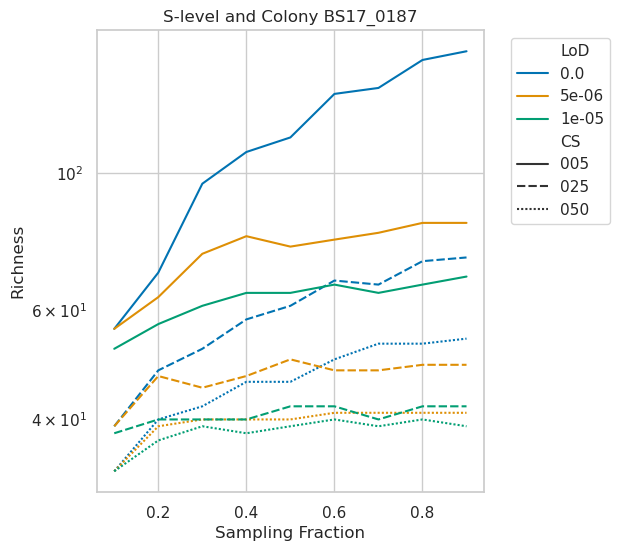

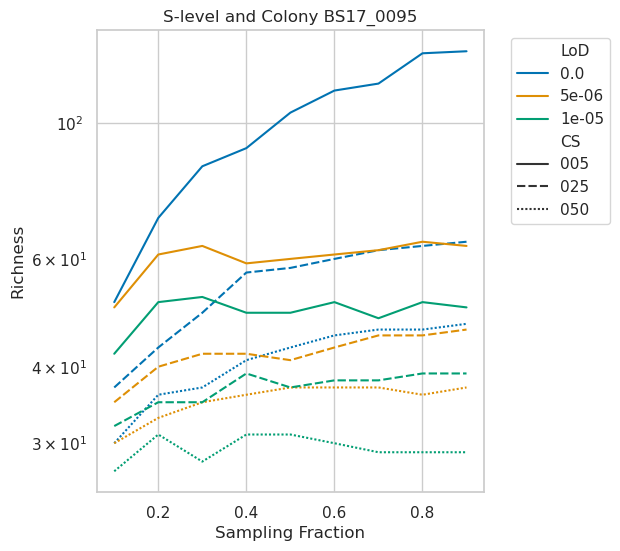

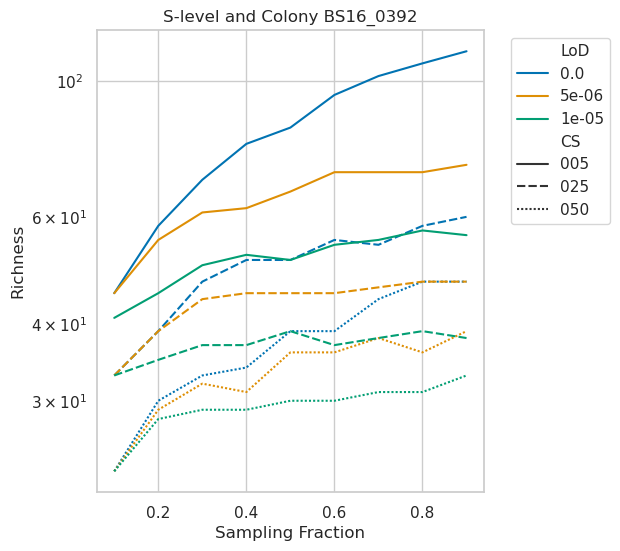

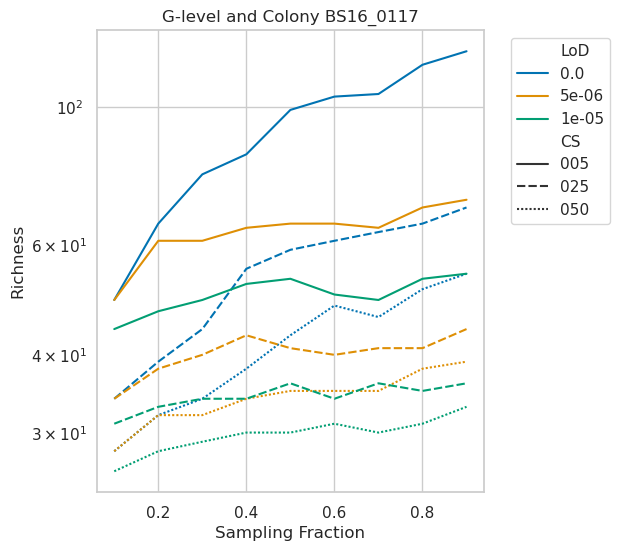

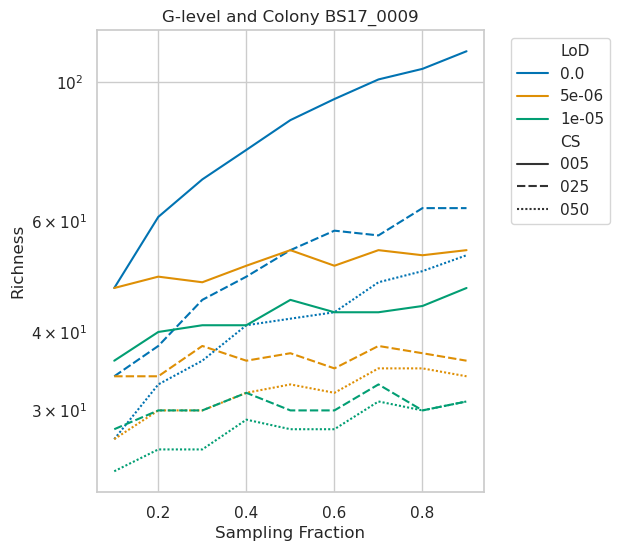

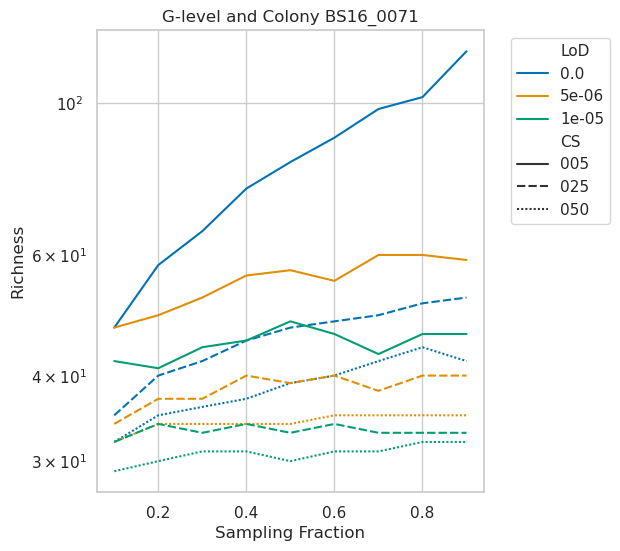

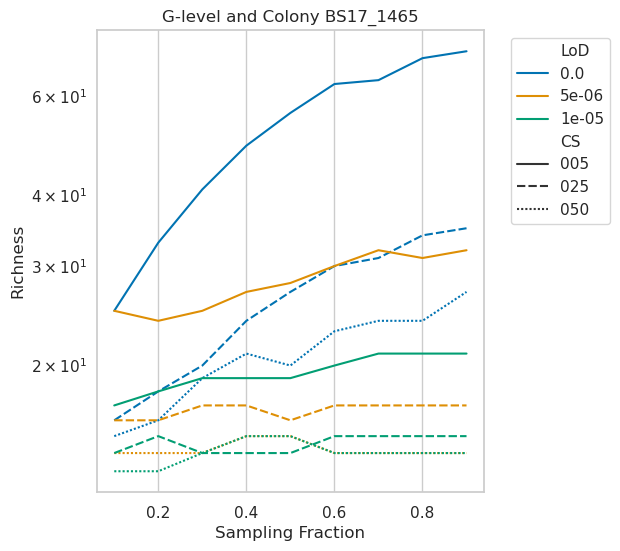

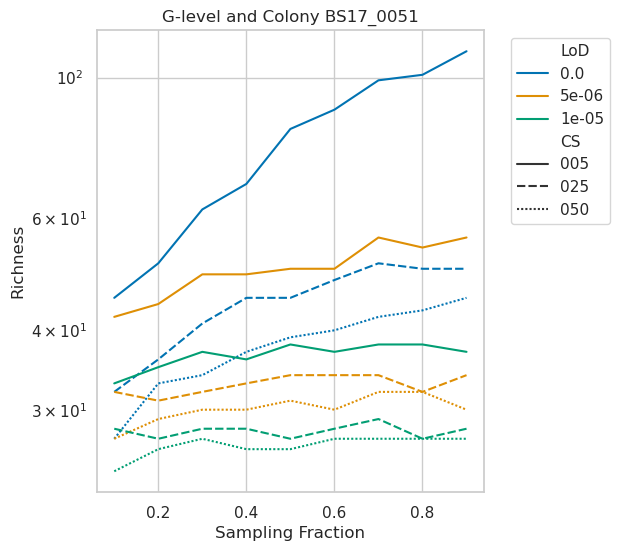

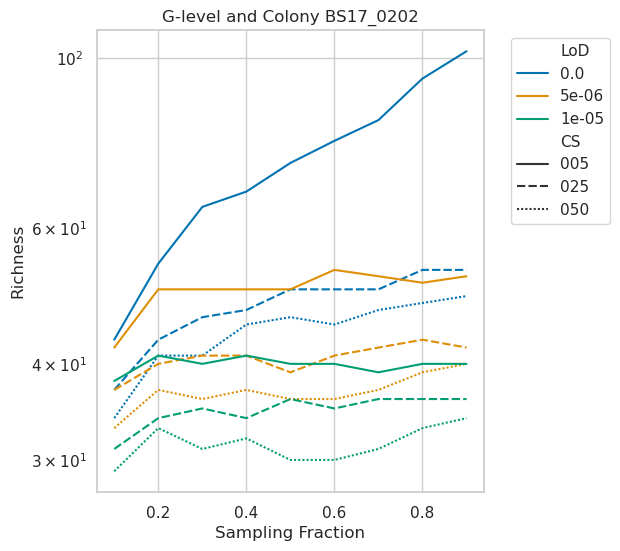

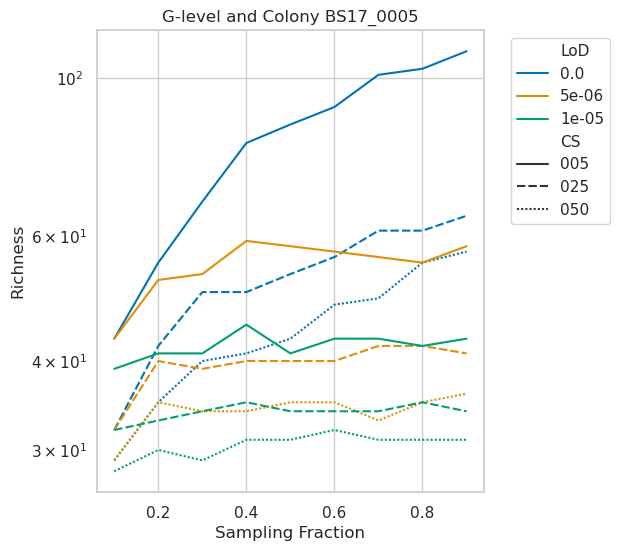

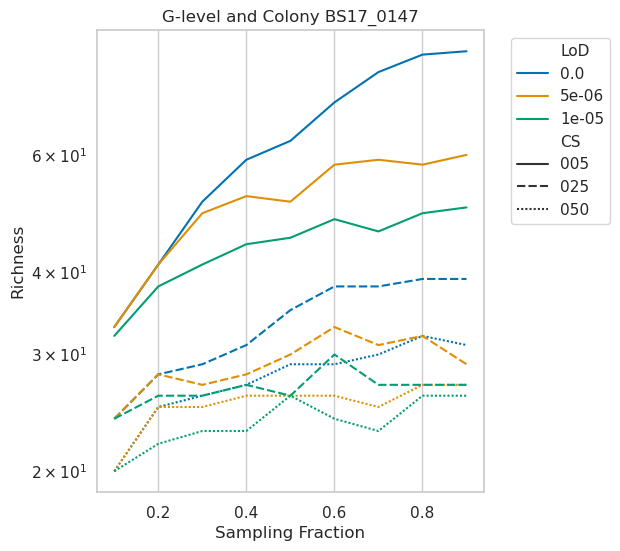

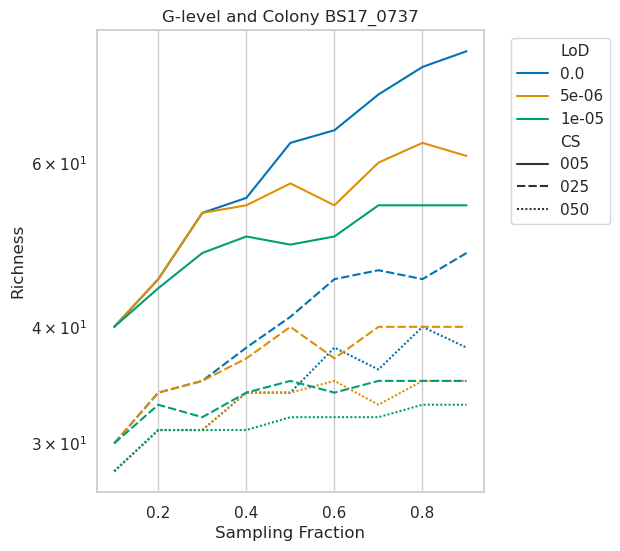

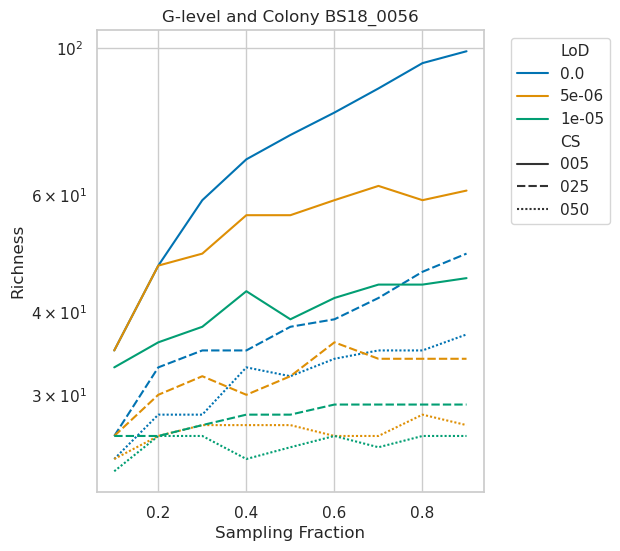

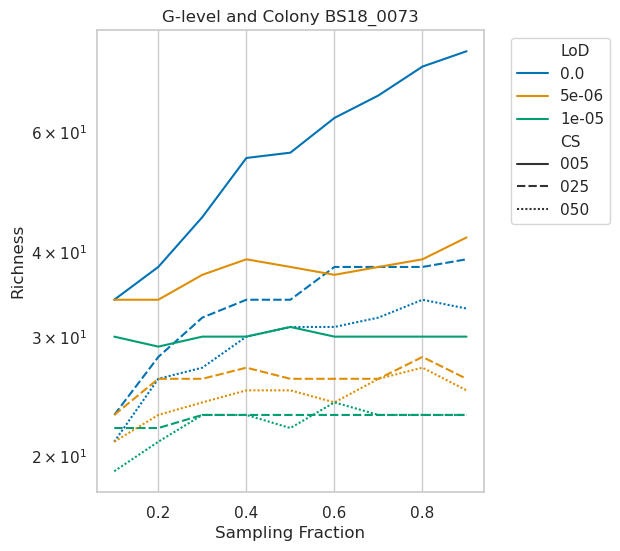

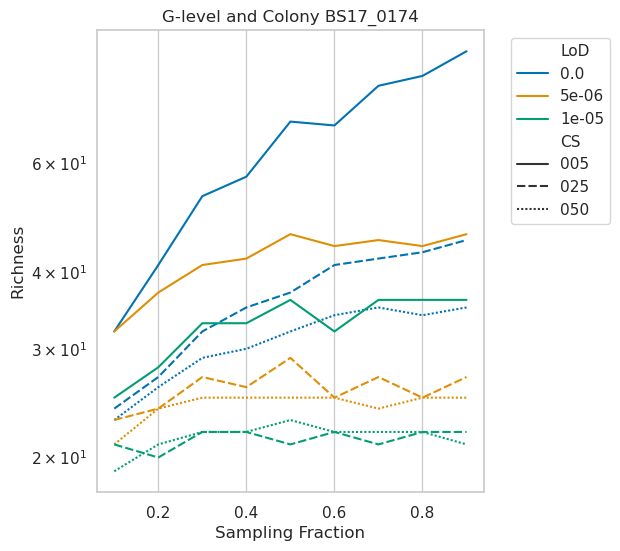

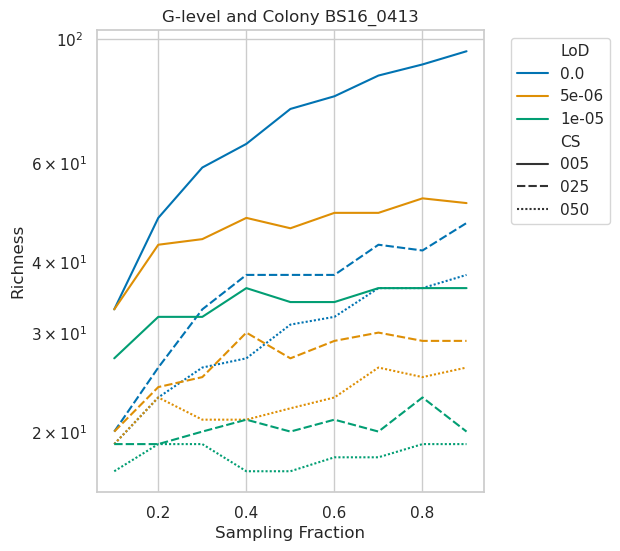

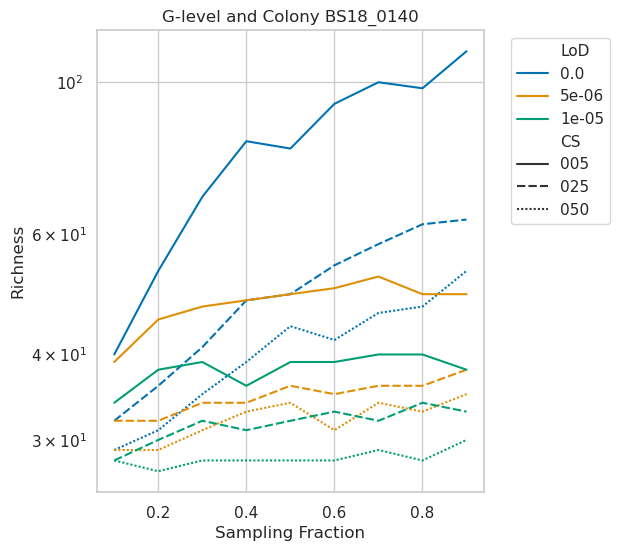

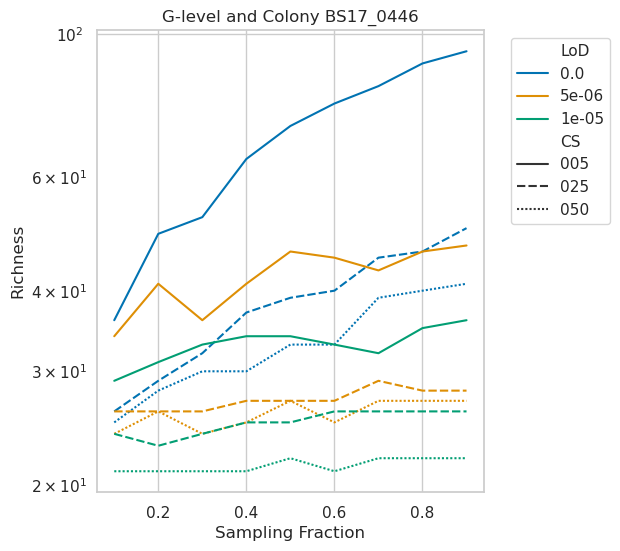

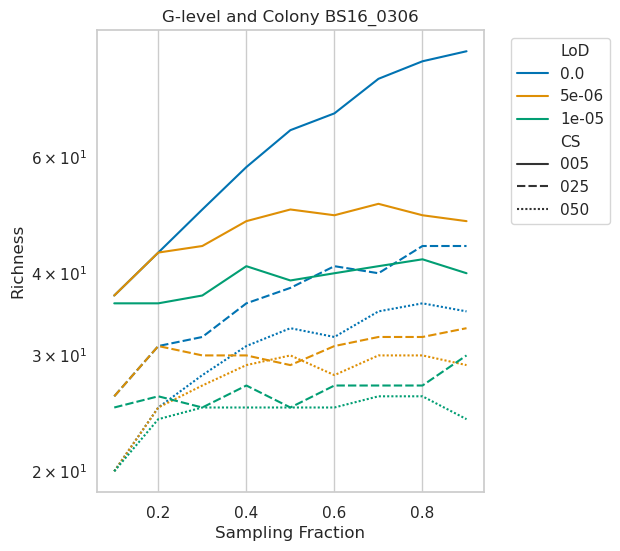

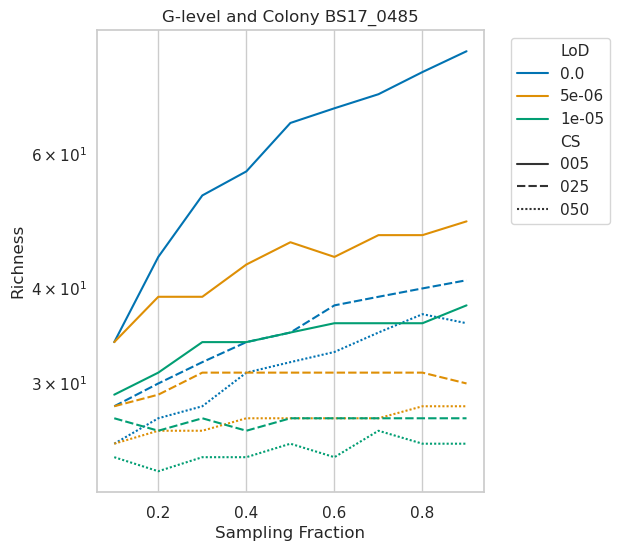

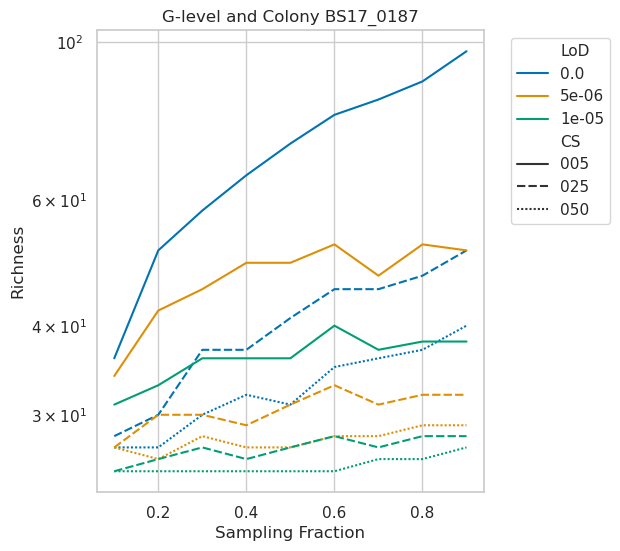

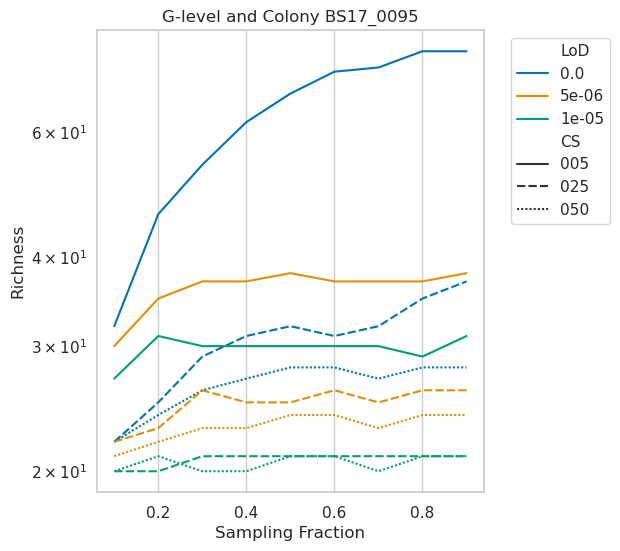

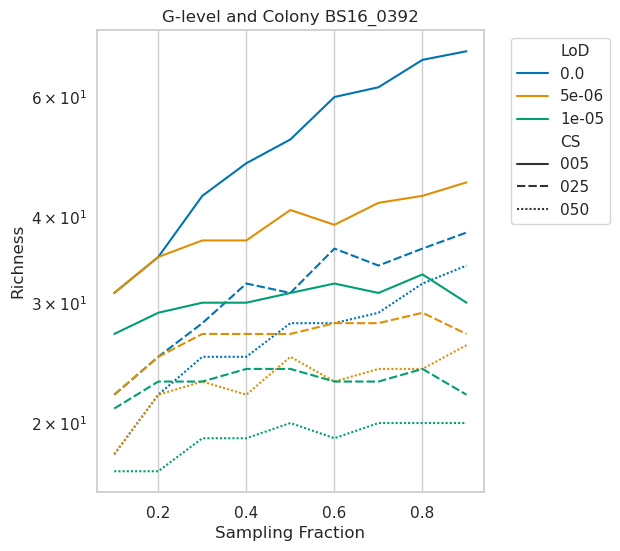

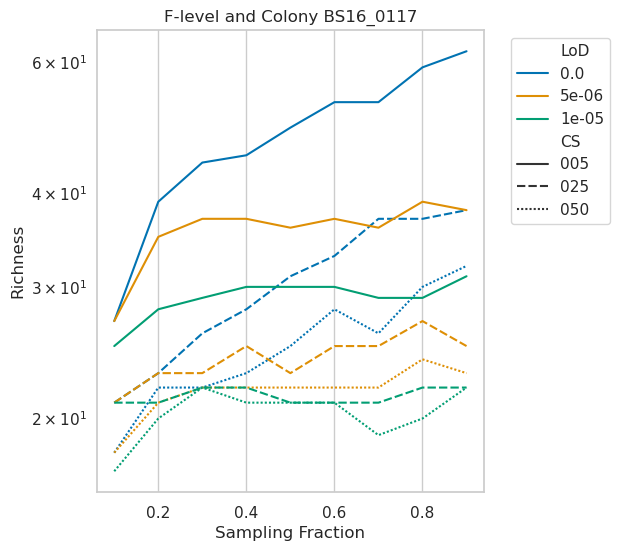

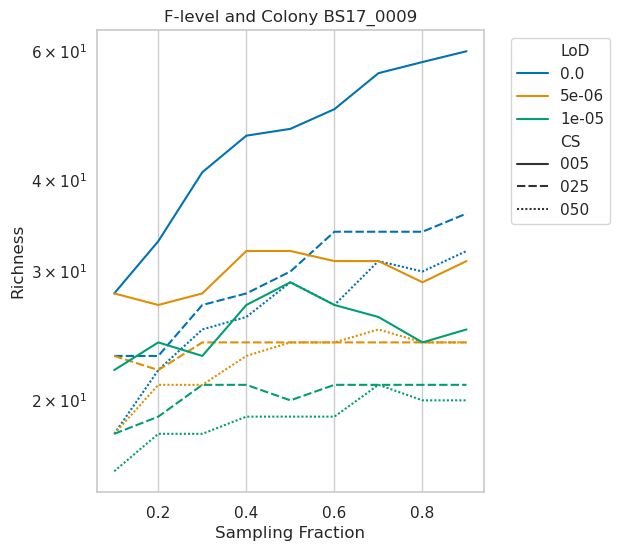

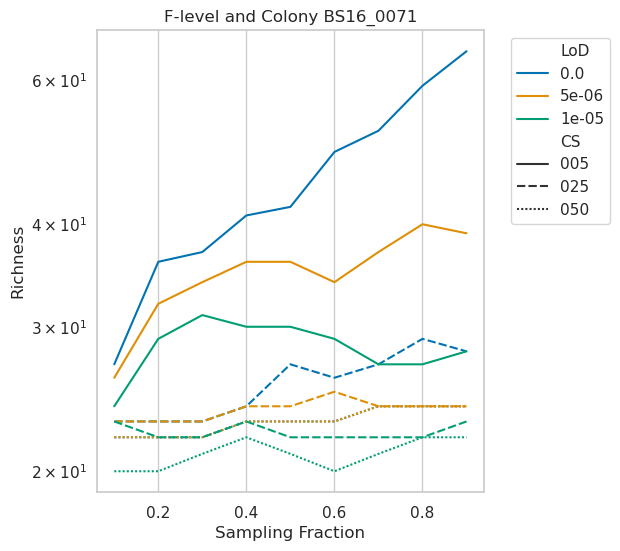

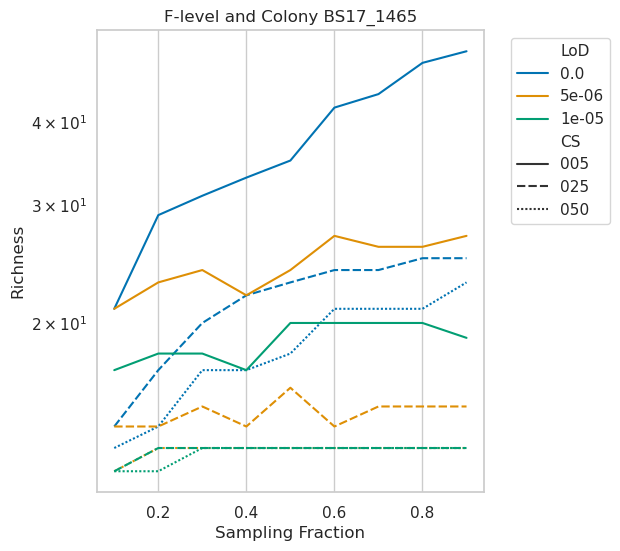

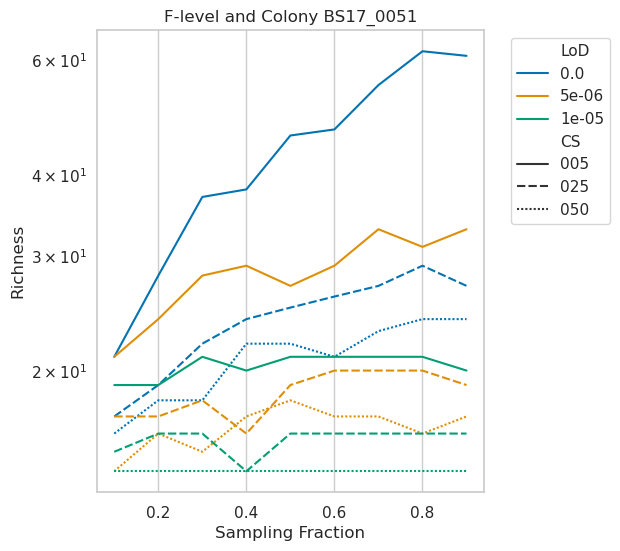

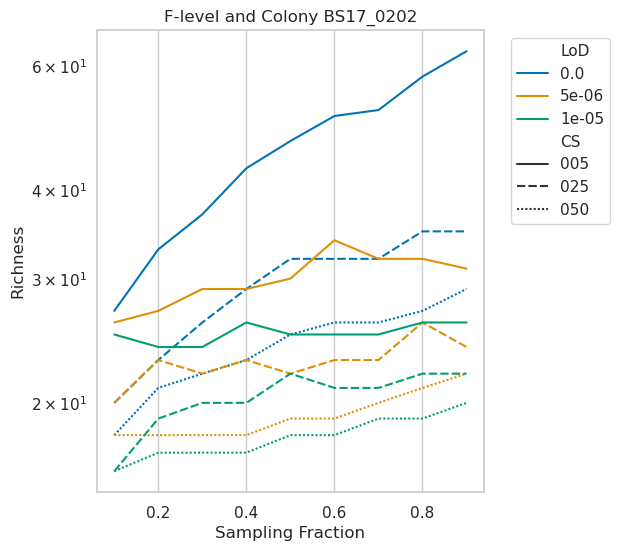

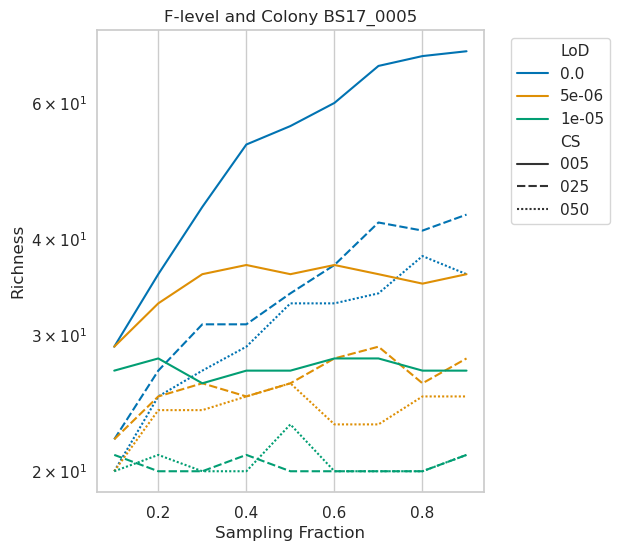

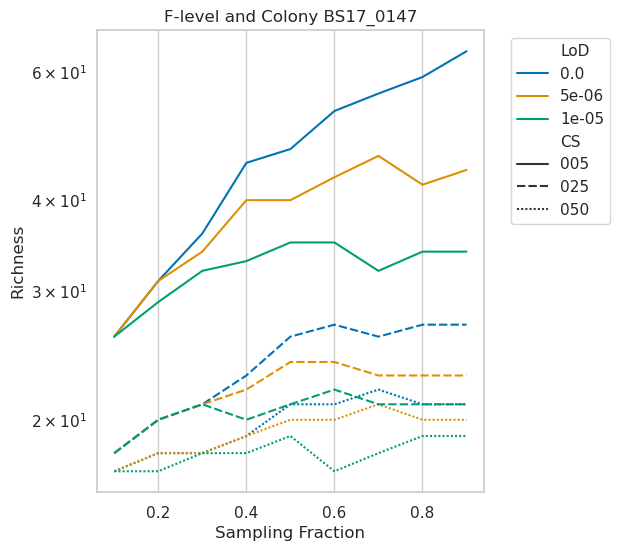

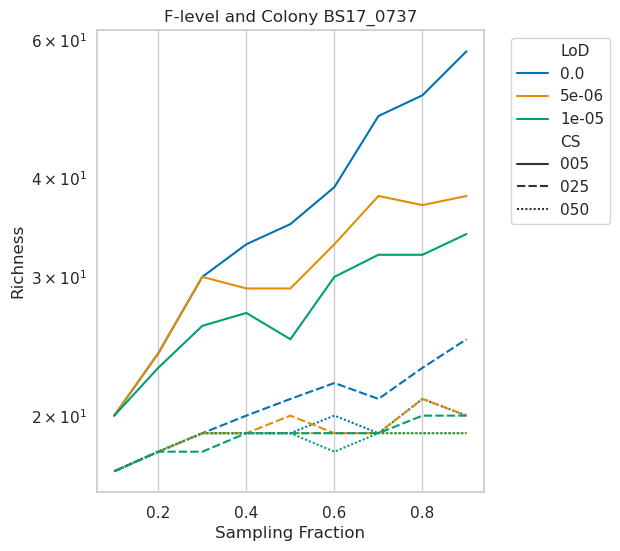

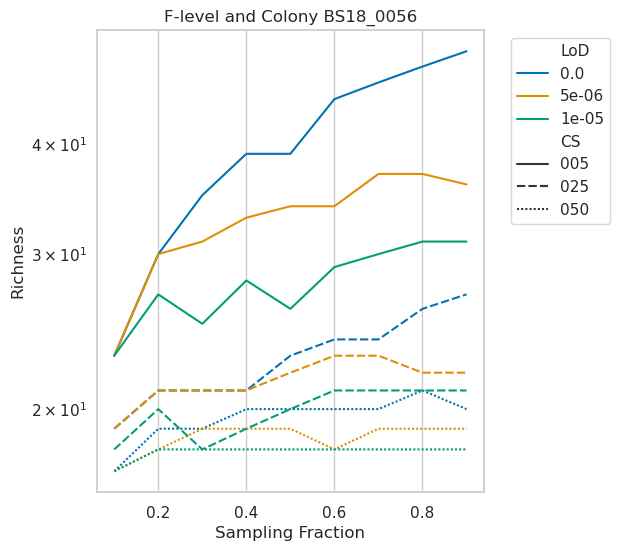

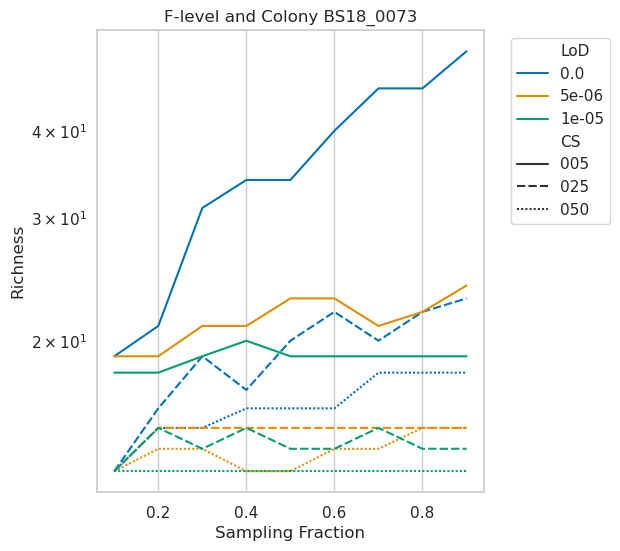

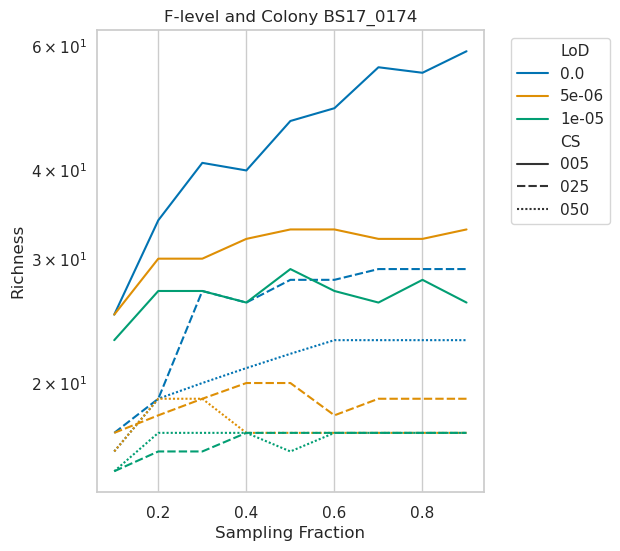

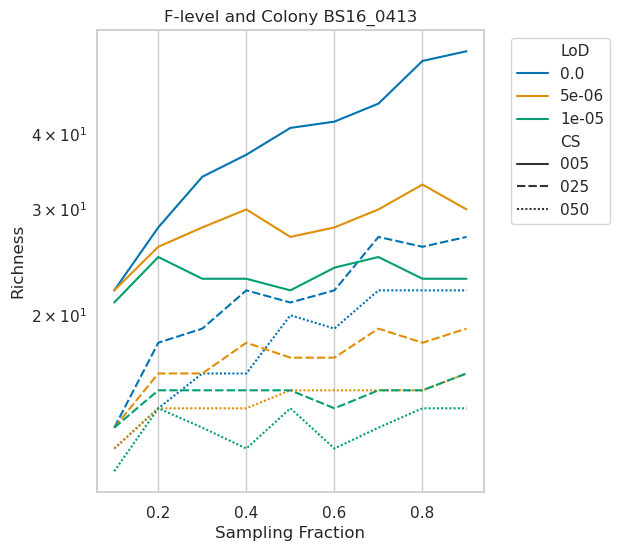

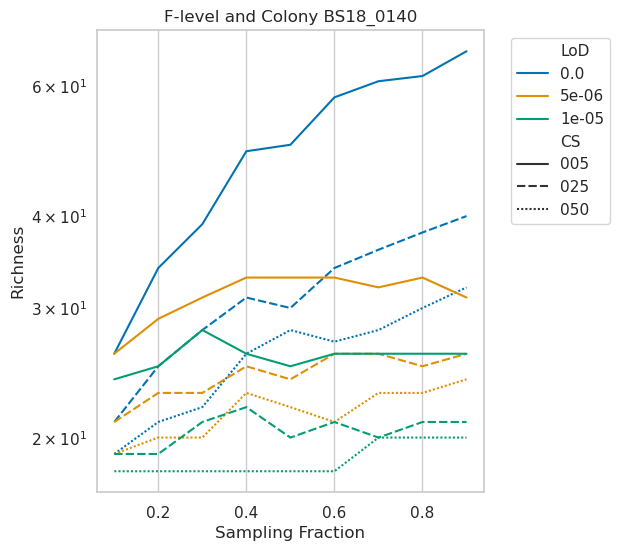

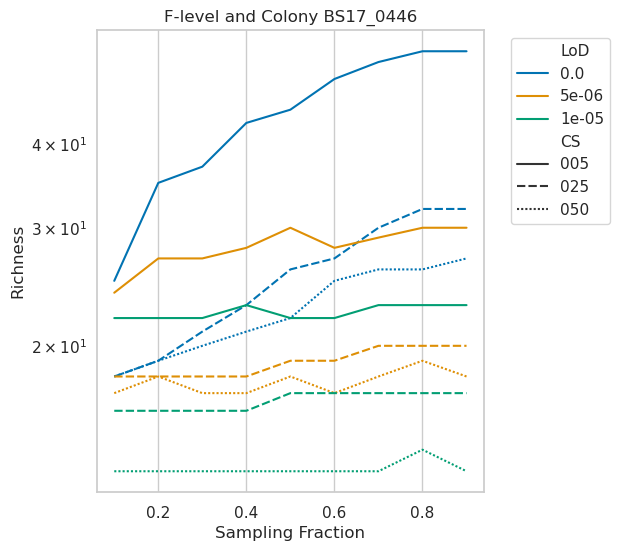

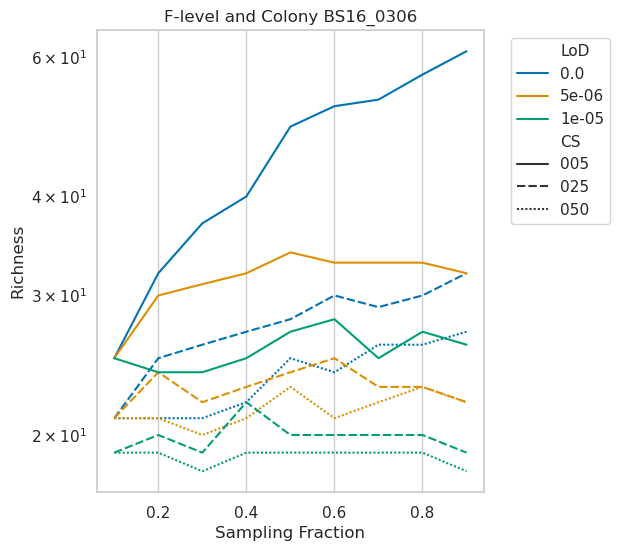

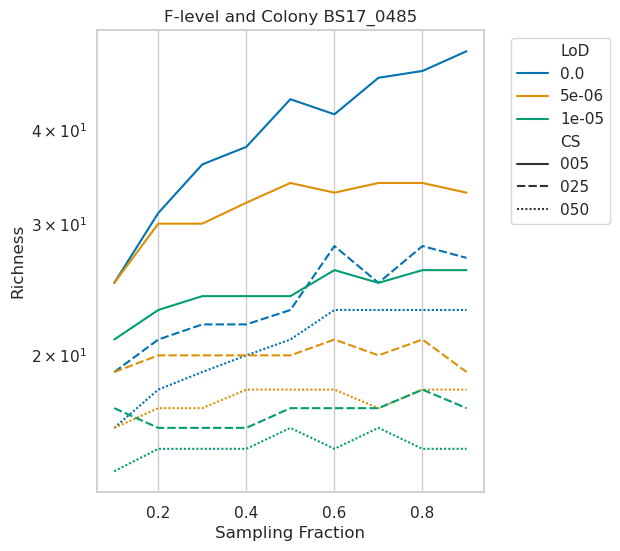

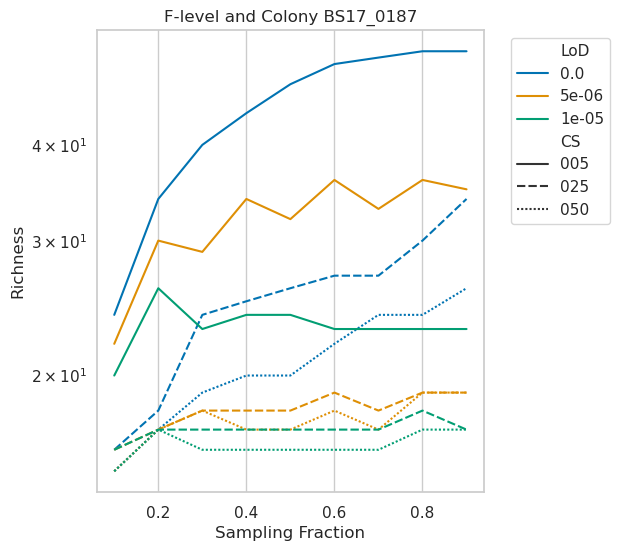

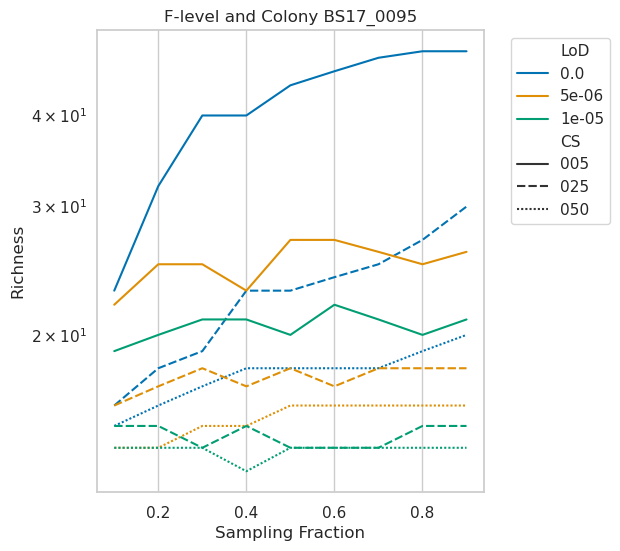

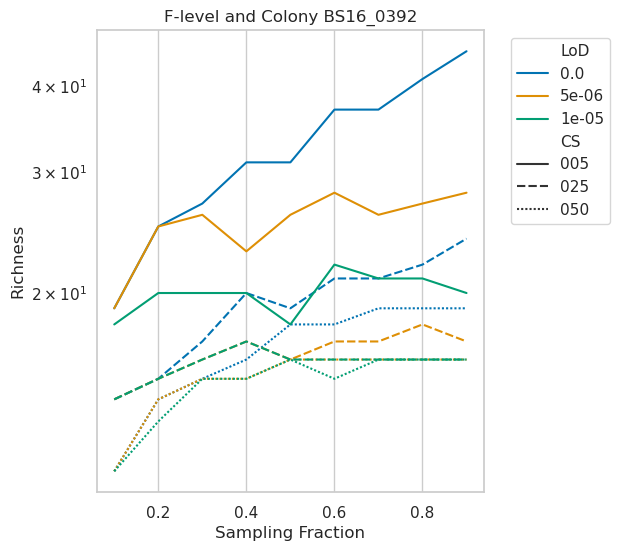

In [225]:
for lvl in levels:
    for bs_id in bs_ids:
        fig, ax = plt.subplots(figsize=(5,6))
        sns.lineplot(data=rare_df[(rare_df['Colony'] == bs_id) & (rare_df['Level'] == lvl)], 
                     x='Sampling Fraction', y='Richness', hue='LoD', style='CS', units='Colony', estimator=None, palette=cmap, ax=ax)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.yscale('log')
        ax.set_title("{}-level and Colony {}".format(lvl, bs_id))
        plt.show()

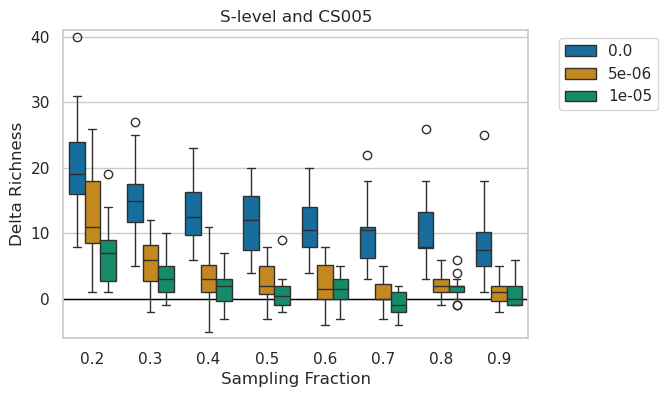

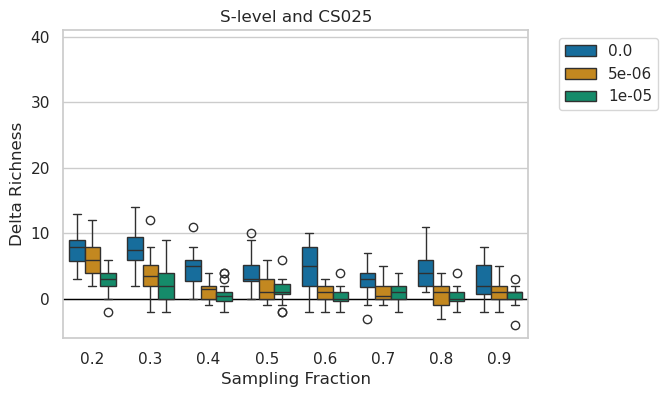

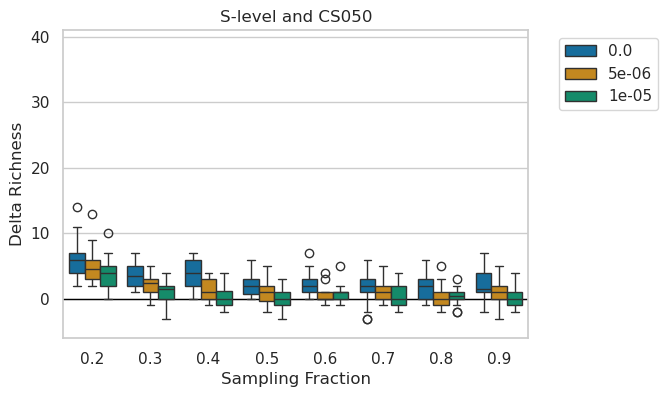

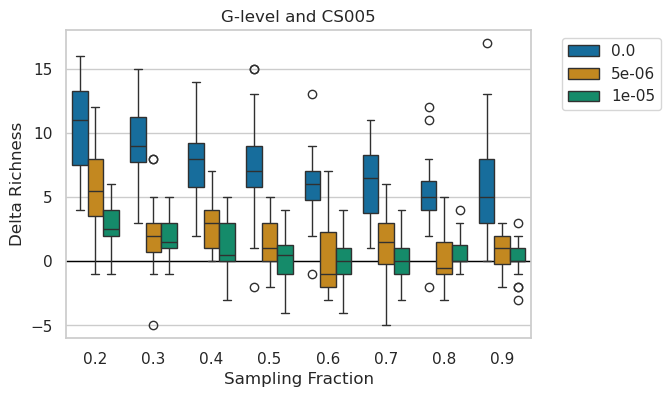

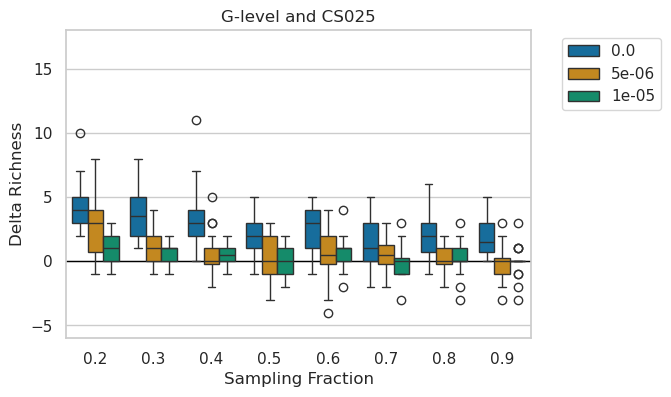

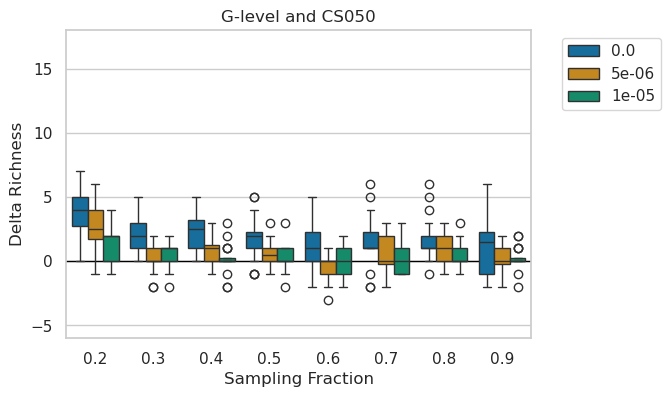

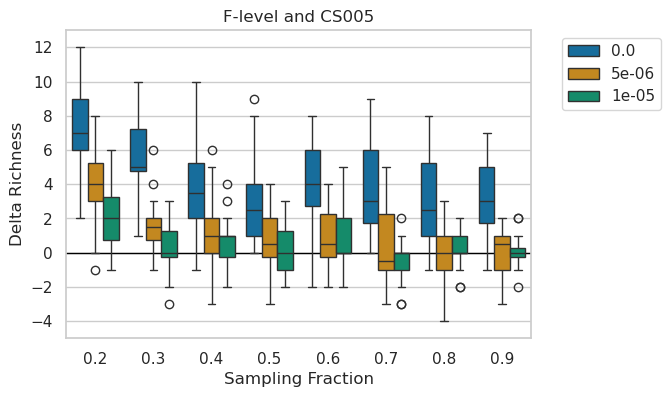

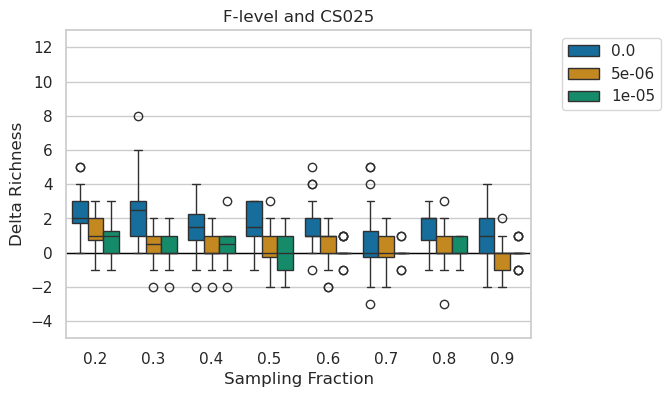

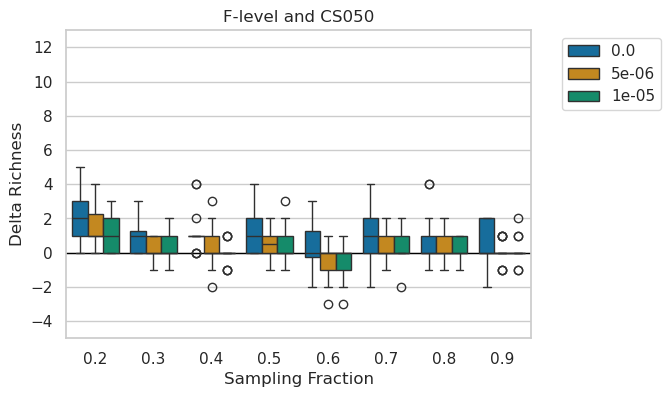

In [218]:
lvl2ylim = {'S': (-6, 41), 'G':(-6, 18), 'F':(-5, 13) }
for lvl in levels:
    for cs in cs_thresholds:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.axhline(0, color='black', linestyle='-', linewidth=1)
        sns.boxplot(data=rare_df[(rare_df['Sampling Fraction'].isin(subsampling_fractions[1:])) & (rare_df['Level'] == lvl) & (rare_df['CS'] == cs)], 
                    x='Sampling Fraction', y='Delta Richness', hue='LoD', palette=cmap, ax=ax)
        ax.set_ylim(lvl2ylim[lvl])
        ax.set_title("{}-level and CS{}".format(lvl, cs))
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # plt.yscale('log')
        plt.show()

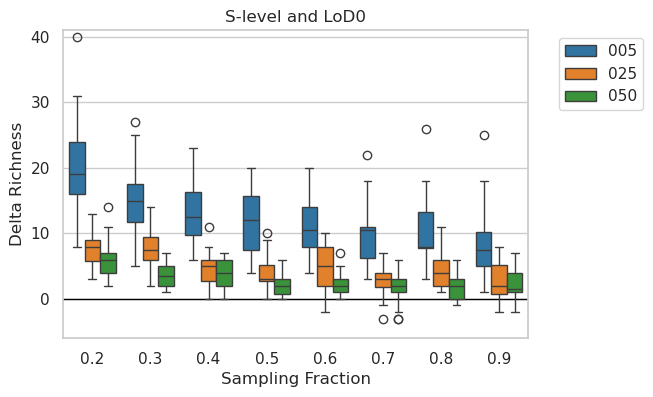

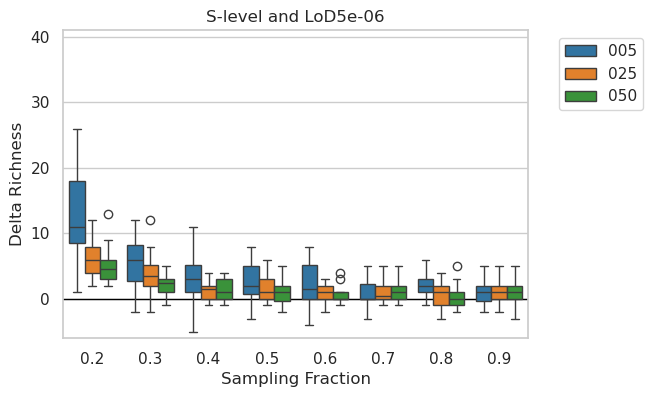

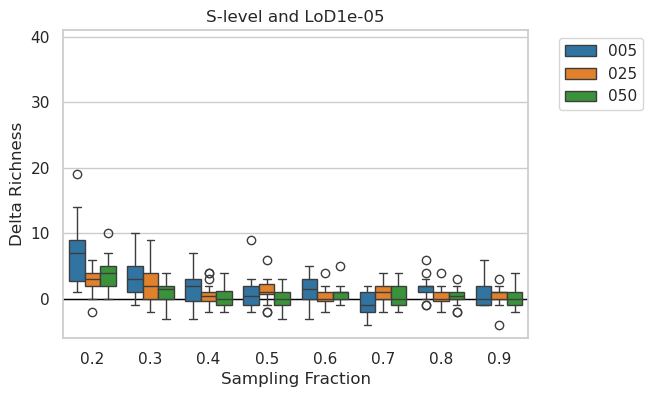

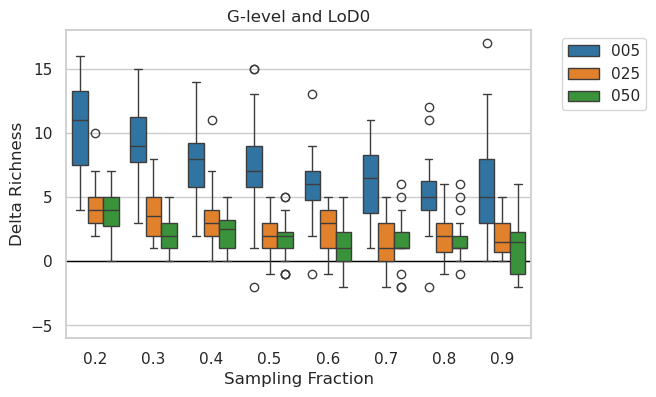

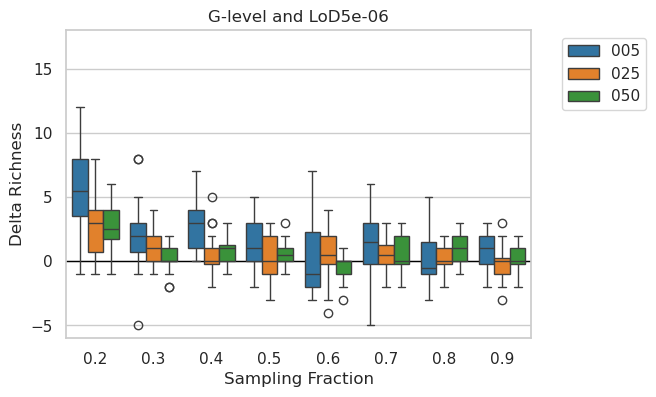

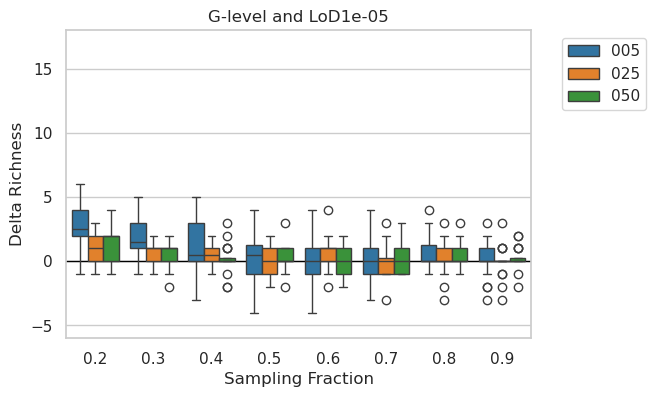

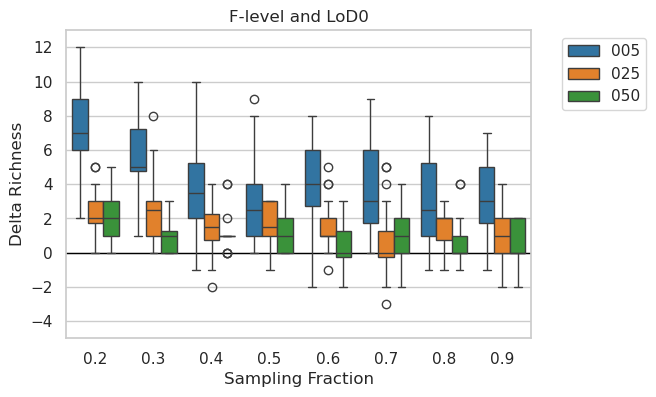

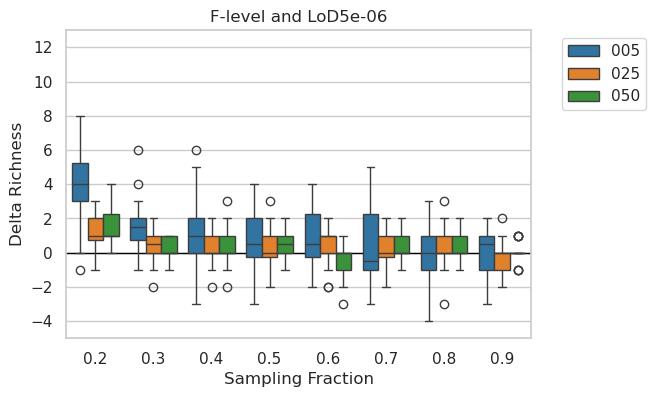

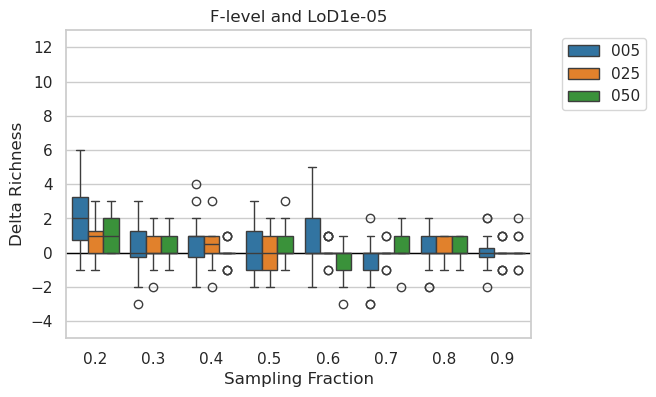

In [220]:
lvl2ylim = {'S': (-6, 41), 'G':(-6, 18), 'F':(-5, 13) }
for lvl in levels:
    for lod in lods:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.axhline(0, color='black', linestyle='-', linewidth=1)
        sns.boxplot(data=rare_df[(rare_df['Sampling Fraction'].isin(subsampling_fractions[1:])) & (rare_df['Level'] == lvl) & (rare_df['LoD'] == lod)], 
                    x='Sampling Fraction', y='Delta Richness', hue='CS', ax=ax)
        ax.set_ylim(lvl2ylim[lvl])
        ax.set_title("{}-level and LoD{}".format(lvl, lod))
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # plt.yscale('log')
        plt.show()

S


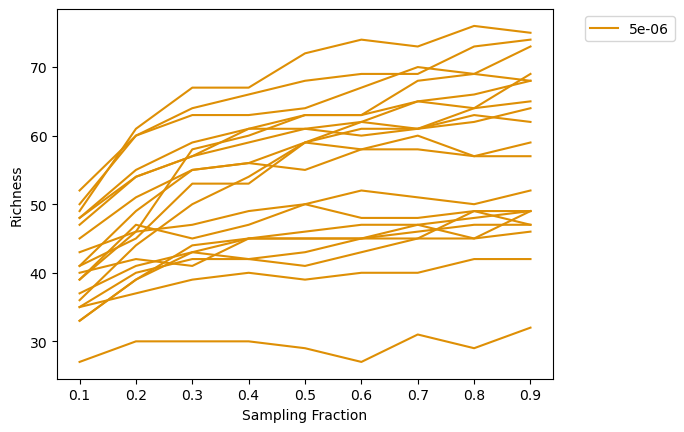

G


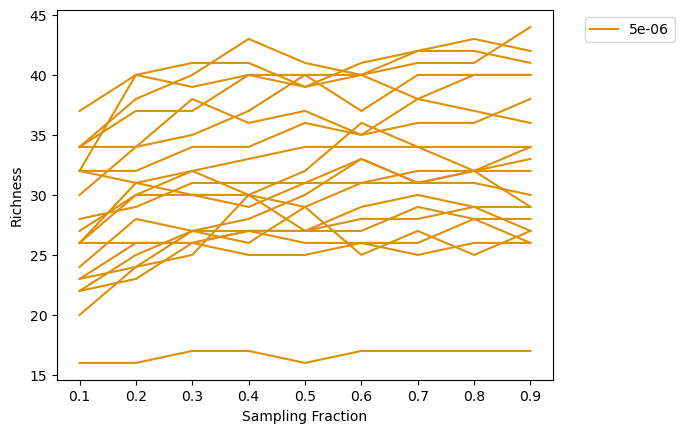

F


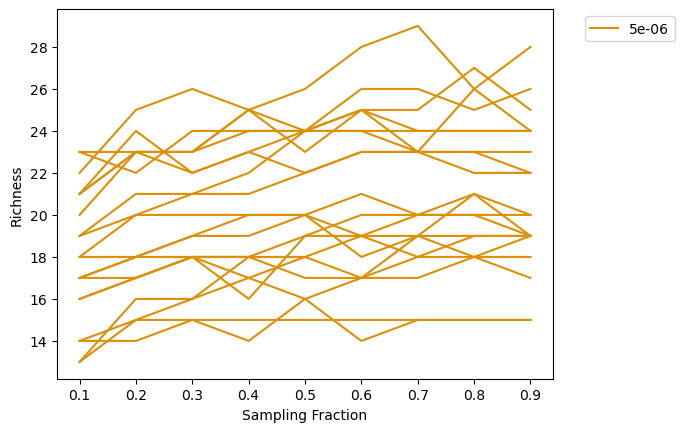

In [205]:
cs = '025'
lod = 5e-06
for lvl in levels:
    print(lvl)
    sns.lineplot(data=rare_df[(rare_df['Level'] == lvl) & (rare_df['CS'] == cs) & (rare_df['LoD'] == lod)], x='Sampling Fraction', y='Richness', hue='LoD', units='Colony', estimator=None, palette=cmap)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.yscale('log')
    
    plt.show()

### BEExact fractions

In [24]:
import requests
from collections import defaultdict

def get_level2beexact_taxa():

    url = "https://raw.githubusercontent.com/bdaisley/BEExact/master/full_database/BEEx_v2023.01.30___FL-refs_taxonomy.txt"
    file_content = requests.get(url, verify=False).text

    level2beexact_taxa = defaultdict(set)
    for level in ['d', 'p', 'c', 'o', 'f', 'g', 's']:
        level2beexact_taxa[level] = set()
    
    for line in file_content.split('\n'):
        if not line: continue
        for s in line.rstrip(';').split('\t')[1].split(';'):
            level, taxon = s.split('__')
            assert level in level2beexact_taxa, print('missing {}'.format(level))
            level2beexact_taxa[level].add(taxon.replace('_', ' '))

    return level2beexact_taxa

In [25]:
level2beexact_taxa = get_level2beexact_taxa()
level2beexact_name2tid = {}
for lvl in ['s', 'g', 'f']:
    level2beexact_name2tid[lvl.upper()] = {name:tids[0] for name, tids in ncbi.get_name_translator(level2beexact_taxa[lvl]).items() if len(tids) == 1} 

/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxy.agsad.admin.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [35]:
array_id2bs_id, bs_id2array_id = read_bs_ids_file(sampled_bs_ids_file)
bs_ids = list(bs_id2array_id)
krakdb, readpool, mhg, sf, r = ('corent', 'nonbee', 2, 1, 1)
cs_thresholds = ['005', '025', '050']
levels = ['S', 'G', 'F']
lods = [1e-6, 5e-06, 1e-05, 5e-05, 1e-04]
lods = [0, 1e-6, 2e-06, 3e-06, 4e-06, 5e-06] #, 6e-06]
lods = [0, 5e-06, 1e-05]

cmap = dict(zip(lods, sns.color_palette('colorblind', len(lods))))

In [41]:
from scipy import stats

columns= ['Colony', 'CS', 'Level', 'LoD', 'Richness', 'BEExact % in Sample (~Precision)', 'Sample % in BEExact (~Sensitivity)', 'F1']
rows = []

for bs_id, cs, lvl in product(bs_ids, cs_thresholds, levels):
        
    brack_df = get_bracken_df(bowtie2_path, kraken2_path, bracken_path, bs_id, krakdb, readpool, mhg, cs, sf, r, lvl, idx_name, {})
    if brack_df.empty:
        continue
    
    for lod in lods:
        lod_brack_df = brack_df[brack_df['fraction_total_reads'] >= lod]
        sample_taxon_nr = len(lod_brack_df)
        beexact_taxon_nr = len(level2beexact_name2tid[lvl])
        overlap_taxon_nr = len(set(lod_brack_df['taxonomy_id']).intersection(level2beexact_name2tid[lvl].values()))
        precision = overlap_taxon_nr / sample_taxon_nr
        sensitivity = overlap_taxon_nr / beexact_taxon_nr
        rows.append((bs_id, cs, lvl, lod, sample_taxon_nr, precision, sensitivity, stats.hmean([precision, sensitivity])))

beexact_df = pd.DataFrame(data=rows, columns=columns)

In [42]:
beexact_df

Colony   CS Level       LoD  Richness  \
0    BS16_0117  005     S  0.000000       332   
1    BS16_0117  005     S  0.000005       116   
2    BS16_0117  005     S  0.000010        84   
3    BS16_0117  005     G  0.000000       178   
4    BS16_0117  005     G  0.000005        73   
..         ...  ...   ...       ...       ...   
535  BS16_0392  050     G  0.000005        24   
536  BS16_0392  050     G  0.000010        20   
537  BS16_0392  050     F  0.000000        23   
538  BS16_0392  050     F  0.000005        16   
539  BS16_0392  050     F  0.000010        16   

     BEExact % in Sample (~Precision)  Sample % in BEExact (~Sensitivity)  \
0                            0.487952                            0.008507   
1                            0.474138                            0.002888   
2                            0.488095                            0.002153   
3                            0.556180                            0.026267   
4                            0.520548                            0.010082   
..                                ...                                 ...   
535                          0.750000                            0.004776   
536                          0.750000                            0.003980   
537                          0.695652                            0.026936   
538                          0.687500                            0.018519   
539                          0.687500                            0.018519   

           F1  
0    0.016723  
1    0.005741  
2    0.004287  
3    0.050165  
4    0.019781  
..        ...  
535  0.009491  
536  0.007918  
537  0.051864  
538  0.036066  
539  0.036066  

[540 rows x 8 columns]

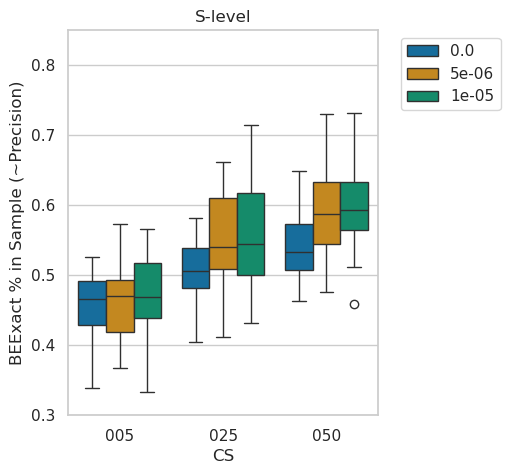

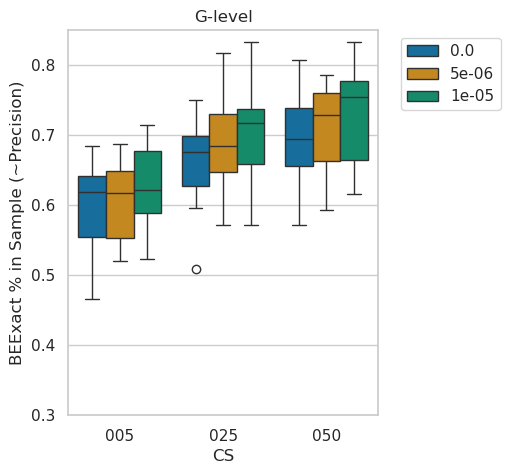

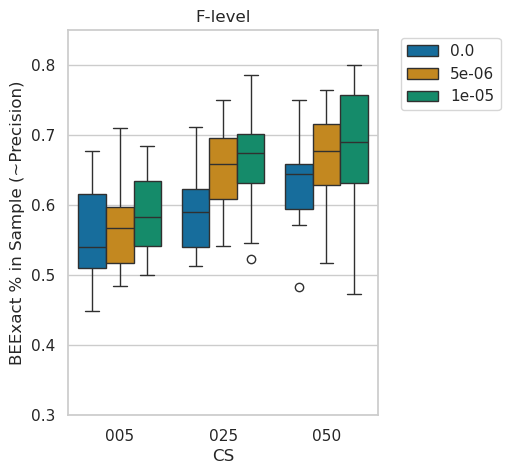

In [43]:
for lvl in levels:
    fig, ax = plt.subplots(figsize=(4,5))
    sns.boxplot(data=beexact_df[beexact_df['Level'] == lvl], x='CS', y='BEExact % in Sample (~Precision)', hue='LoD', palette=cmap, ax=ax)
    ax.set_ylim((0.30, 0.85))
    ax.set_title("{}-level".format(lvl))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

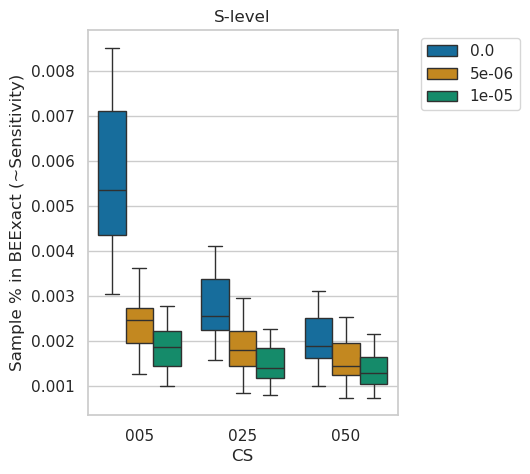

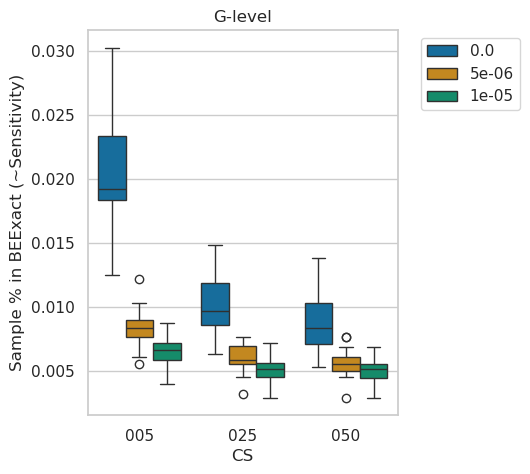

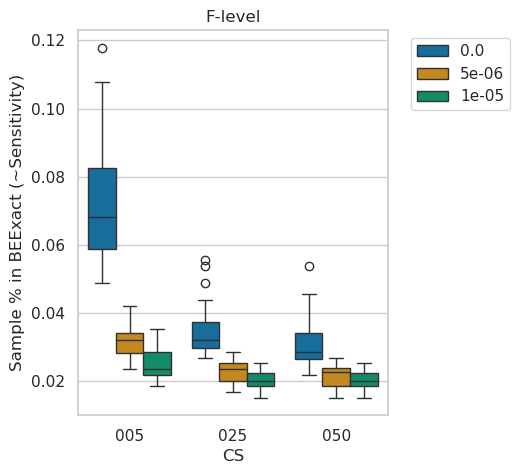

In [44]:
for lvl in levels:
    fig, ax = plt.subplots(figsize=(4,5))
    sns.boxplot(data=beexact_df[beexact_df['Level'] == lvl], x='CS', y='Sample % in BEExact (~Sensitivity)', hue='LoD', palette=cmap, ax=ax)
    # ax.set_ylim((0.30, 0.85))
    ax.set_title("{}-level".format(lvl))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

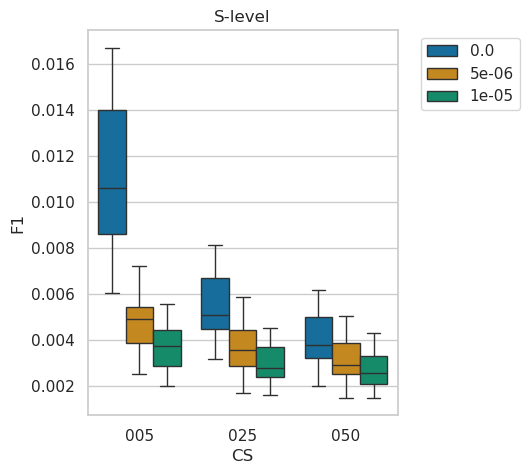

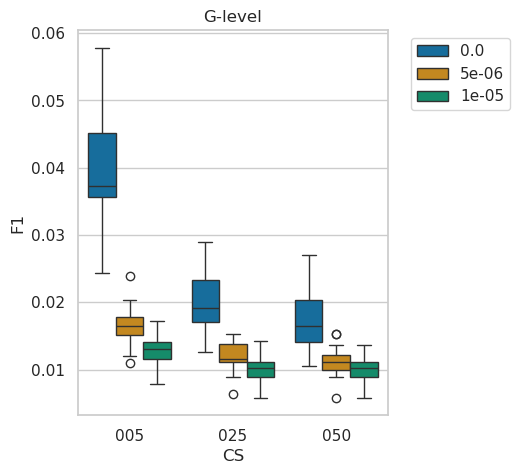

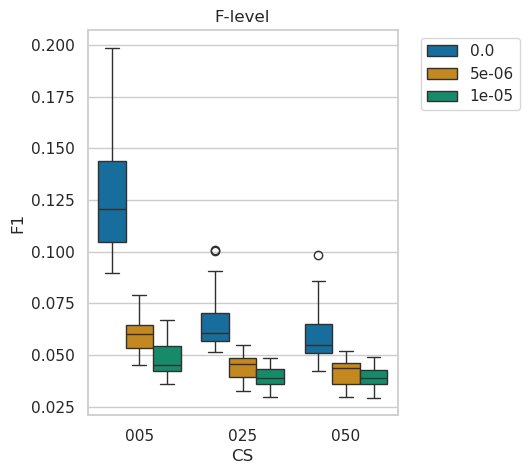

In [45]:
for lvl in levels:
    fig, ax = plt.subplots(figsize=(4,5))
    sns.boxplot(data=beexact_df[beexact_df['Level'] == lvl], x='CS', y='F1', hue='LoD', palette=cmap, ax=ax)
    # ax.set_ylim((0.30, 0.85))
    ax.set_title("{}-level".format(lvl))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Genomic Varroa load phenotyping